In [1]:
import sys
print(sys.version)
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe_connected'
import plotly.offline as py
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import itertools
import time
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from scipy.spatial import cKDTree
from plotly.validators.scatter.marker import SymbolValidator
import tensorflow as tf
from scipy.spatial import KDTree
import simpsom as sps

3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]


2024-09-03 18:13:17.875432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 18:13:17.886583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 18:13:17.889910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 18:13:17.899065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 18:13:18.617723: W tensorflow/compiler/tf2

In [2]:
def plot_3d_points(points, scale):
    # Calculate the distance of each point from the origin
    distances = np.sqrt(np.sum(np.array(points)**2, axis=1))

    # Normalize the distances to use in the color scale
    normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    # Create a 3D scatter plot for the points
    trace = go.Scatter3d(
        x=[point[0] for point in points],
        y=[point[1] for point in points],
        z=[point[2] for point in points],
        mode='markers',
        marker=dict(
            size=5,
            color=normalized_distances,  # Use normalized distances for color
            colorscale='Viridis',  # You can choose a different colorscale
            colorbar=dict(title='Distance from Origin')
        )
    )

    # Set layout for the 3D plot with manual axis range
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=700,  # Set the width of the plot window
        height=700,  # Set the height of the plot window
    )

    # Create a figure and add the trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the plot
    fig.show()

# Example usage:
# points is a list of [x, y, z] coordinates, for example: [[x1, y1, z1], [x2, y2, z2], ...]
# scale is the scale of the plot, for example: [10, 10, 10]
# plot_3d_points(points, scale=[10, 10, 10])

In [3]:
def create_sphere(center=[0, 0, 0], radius=1, opacity=0.2, color='blue'):
    # Generate a sphere centered at 'center' and with given 'radius'
    phi, theta = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)

    return go.Surface(x=x, y=y, z=z, opacity=opacity, showscale=False, colorscale=[[0, color], [1, color]])

In [4]:
def plot_3d_pointsSp(points, scale):
    # Calculate the distance of each point from the origin
    distances = np.sqrt(np.sum(np.array(points)**2, axis=1))

    # Closest and furthest points
    closest_point = points[np.argmin(distances)]
    furthest_point = points[np.argmax(distances)]
    closest_distance = np.min(distances)
    furthest_distance = np.max(distances)

    print("near: ", closest_distance)
    print("far: ", furthest_distance)
    # Normalize the distances to use in the color scale
    normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    # Create a 3D scatter plot for the points
    trace = go.Scatter3d(
        x=[point[0] for point in points],
        y=[point[1] for point in points],
        z=[point[2] for point in points],
        mode='markers',
        marker=dict(
            size=5,
            color=normalized_distances,  # Use normalized distances for color
            colorscale='Viridis',  # You can choose a different colorscale
            colorbar=dict(title='Distance from Origin')
        )
    )

    # Spheres at the closest and furthest points
    closest_sphere = create_sphere(center=[0,0,0], radius=closest_distance, opacity=0.2, color='green')
    furthest_sphere = create_sphere(center=[0,0,0], radius=furthest_distance, opacity=0.2, color='red')

    # Set layout for the 3D plot with manual axis range
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=700,  # Set the width of the plot window
        height=700,  # Set the height of the plot window
    )

    # Create a figure and add the traces
    fig = go.Figure(data=[trace, closest_sphere, furthest_sphere], layout=layout)

    # Show the plot
    fig.show()

# Example usage with your points and scale
# plot_3d_points(points, scale=[10, 10, 10])

In [5]:
def plot_3d_density(points, scale, radius=1):
    # Create a KDTree for efficient neighbor search
    kdtree = cKDTree(points)

    # For each point, count the number of neighbors within the specified radius
    densities = np.array([len(kdtree.query_ball_point(point, radius)) for point in points])

    # Normalize the densities to use in the color scale
    normalized_densities = (densities - np.min(densities)) / (np.max(densities) - np.min(densities))

    # Create a 3D scatter plot for the points
    trace = go.Scatter3d(
        x=[point[0] for point in points],
        y=[point[1] for point in points],
        z=[point[2] for point in points],
        mode='markers',
        marker=dict(
            size=5,
            color=normalized_densities,  # Use normalized densities for color
            colorscale='Viridis',  # You can choose a different colorscale
            colorbar=dict(title='Point Density')
        )
    )

    # Set layout for the 3D plot with manual axis range
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=700,  # Set the width of the plot window
        height=700,  # Set the height of the plot window
    )

    # Create a figure and add the trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the plot
    fig.show()

# Example usage:
# points is a list of [x, y, z] coordinates, for example: [[x1, y1, z1], [x2, y2, z2], ...]
# scale is the scale of the plot, for example: [10, 10, 10]
# plot_3d_density(points, scale=[10, 10, 10], radius=1)

In [6]:
def plot_3d_arm_simple(arm_points, scale):
    # Create a 3D scatter plot for the arm points with different colors for each segment
    trace = go.Scatter3d(
        x=[point[0] for point in arm_points],
        y=[point[1] for point in arm_points],
        z=[point[2] for point in arm_points],
        mode='markers+lines',
        marker=dict(
            size=4,
            symbol='circle-open',
            color=[i for i in range(len(arm_points))],  # Assign a color based on the segment
            colorscale='Viridis'  # You can choose a different colorscale
        ),
        line=dict(
            color=[i for i in range(len(arm_points))],  # Use the same color array for lines
            colorscale='Viridis'  # You can choose a different colorscale
        )
    )

    # Set layout for the 3D plot with manual axis range
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),  # Set the range for the X-axis
            yaxis=dict(range=[-scale[1], scale[1]]),  # Set the range for the Y-axis
            zaxis=dict(range=[-scale[2], scale[2]]),  # Set the range for the Z-axis
            aspectmode="cube"
        ),
        width=600,  # Set the width of the plot window
        height=600,  # Set the height of the plot window
    )

    # Create a figure and add the trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the plot
    fig.show()

# Example usage:
# arm_points is a list of points representing the arm configuration in one frame
# For example, arm_points = [[x1, y1, z1], [x2, y2, z2], ...]
# scale is the scale of the plot
# plot_3d_arm(arm_points, scale=[10, 10, 10])

In [7]:
def plot_3d_arm8(arm_points_frames, scale, cf):
    # Create a list to store frames for animation
    frames = []

    # Iterate through each frame of arm_points
    for i, frame_points in enumerate(arm_points_frames):
        # Create a 3D scatter plot for the arm points with different colors for each segment
        trace = go.Scatter3d(
            x=[point[0] for point in frame_points],
            y=[point[1] for point in frame_points],
            z=[point[2] for point in frame_points],
            mode='markers+lines',
            marker=dict(
                size=4,
                symbol='circle-open',
                color=[i // cf for i in range(len(frame_points))],  # Assign a color based on the segment
                colorscale='Viridis'  # You can choose a different colorscale
            ),
            line=dict(
                # size=2,
                color=[i // cf for i in range(len(frame_points))],  # Use the same color array for lines
                colorscale='Viridis'  # You can choose a different colorscale
            )
        )

        # Append the trace to frames
        frame = go.Frame(data=[trace], name=f'frame{i}')
        frames.append(frame)

    # Set layout for the 3D plot with manual axis range and larger window size
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),  # Set the range for the X-axis
            yaxis=dict(range=[-scale[1], scale[1]]),  # Set the range for the Y-axis
            zaxis=dict(range=[-scale[2], scale[2]]),  # Set the range for the Z-axis
            aspectmode="cube"
        ),
        width=600,  # Set the width of the plot window
        height=600,  # Set the height of the plot window
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[dict(label='Play',
                          method='animate',
                          args=[None, dict(frame=dict(duration=10, redraw=True), fromcurrent=True)])]
        )]
    )

    # Create a figure and add the trace and frames
    fig = go.Figure(data=[trace], layout=layout, frames=frames)

    # Show the plot
    fig.show()

# Example usage:
# arm_points_frames is a list of lists, where each inner list represents the arm points for a frame
# For example, arm_points_frames = [[[x1, y1, z1], [x2, y2, z2], ...], [...], ...]
# scale is the scale of the plot, cf is the color factor
# plot_3d_arm7(arm_points_frames, scale=[10, 10, 10], cf=10)

In [8]:
def plot_3d_arm9(arm_points_frames, scale, cf):
    # Create the base trace
    base_trace = go.Scatter3d(
        x=[point[0] for point in arm_points_frames[0]],
        y=[point[1] for point in arm_points_frames[0]],
        z=[point[2] for point in arm_points_frames[0]],
        mode='markers+lines',
        marker=dict(
            size=4,
            symbol='circle-open',
            color=[i // cf for i in range(len(arm_points_frames[0]))],  # Assign a color based on the segment
            colorscale='Viridis'  # You can choose a different colorscale
        ),
        line=dict(
            color=[i // cf for i in range(len(arm_points_frames[0]))],  # Use the same color array for lines
            colorscale='Viridis'  # You can choose a different colorscale
        )
    )

    # Create frames
    frames = []
    for i, frame_points in enumerate(arm_points_frames):
        frame = go.Frame(
            data=[go.Scatter3d(
                x=[point[0] for point in frame_points],
                y=[point[1] for point in frame_points],
                z=[point[2] for point in frame_points],
                mode='markers+lines',
                marker=dict(
                    size=4,
                    symbol='circle-open',
                    color=[i // cf for i in range(len(frame_points))],  # Assign a color based on the segment
                    colorscale='Viridis'  # You can choose a different colorscale
                ),
                line=dict(
                    color=[i // cf for i in range(len(frame_points))],  # Use the same color array for lines
                    colorscale='Viridis'  # You can choose a different colorscale
                )
            )],
            name=str(i)
        )
        frames.append(frame)

    # Set layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=600,
        height=600,
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[dict(label='Play',
                          method='animate',
                          args=[None, dict(frame=dict(duration=30, redraw=True), fromcurrent=True)])]
        )],
        sliders=[dict(
            steps=[dict(method='animate', args=[[str(i)], 
                                                dict(mode='immediate', frame=dict(duration=100, redraw=True))],
                  label=str(i)) for i in range(len(arm_points_frames))],
            active=0,
            currentvalue={"prefix": "Frame: "}
        )]
    )

    # Create figure
    fig = go.Figure(data=[base_trace], layout=layout, frames=frames)

    # Show the plot
    fig.show()

# Example usage:
# arm_points_frames is a list of lists, where each inner list represents the arm points for a frame
# For example, arm_points_frames = [[[x1, y1, z1], [x2, y2, z2], ...], [...], ...]
# scale is the scale of the plot, cf is the color factor
# plot_3d_arm8(arm_points_frames, scale=[10, 10, 10], cf=10)


In [9]:
def plot_3d_arm10(arm_points_frames, scale, cf):
    # Define alternating colors
    colors = ['black', 'red'] * (len(arm_points_frames[0]) // 2 + 1)

    # Create the base trace
    base_trace = go.Scatter3d(
        x=[point[0] for point in arm_points_frames[0]],
        y=[point[1] for point in arm_points_frames[0]],
        z=[point[2] for point in arm_points_frames[0]],
        mode='markers+lines',
        marker=dict(
            size=4,
            symbol='circle-open',
            color=[colors[i // cf] for i in range(len(arm_points_frames[0]))]  # Assign black and red alternately
        ),
        line=dict(
            color=[colors[i // cf] for i in range(len(arm_points_frames[0]))]  # Assign black and red alternately
        )
    )

    # Create frames
    frames = []
    for i, frame_points in enumerate(arm_points_frames):
        frame = go.Frame(
            data=[go.Scatter3d(
                x=[point[0] for point in frame_points],
                y=[point[1] for point in frame_points],
                z=[point[2] for point in frame_points],
                mode='markers+lines',
                marker=dict(
                    size=4,
                    symbol='circle-open',
                    color=[colors[i // cf] for i in range(len(frame_points))]  # Assign black and red alternately
                ),
                line=dict(
                    color=[colors[i // cf] for i in range(len(frame_points))]  # Assign black and red alternately
                )
            )],
            name=str(i)
        )
        frames.append(frame)

    # Set layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(range=[-scale[0], scale[0]]),
            yaxis=dict(range=[-scale[1], scale[1]]),
            zaxis=dict(range=[-scale[2], scale[2]]),
            aspectmode="cube"
        ),
        width=600,
        height=600,
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[dict(label='Play',
                          method='animate',
                          args=[None, dict(frame=dict(duration=30, redraw=True), fromcurrent=True)])]
        )],
        sliders=[dict(
            steps=[dict(method='animate', args=[[str(i)], 
                                                dict(mode='immediate', frame=dict(duration=100, redraw=True))],
                  label=str(i)) for i in range(len(arm_points_frames))],
            active=0,
            currentvalue={"prefix": "Frame: "}
        )]
    )

    # Create figure
    fig = go.Figure(data=[base_trace], layout=layout, frames=frames)

    # Show the plot
    fig.show()

# Example usage:
# arm_points_frames is a list of lists, where each inner list represents the arm points for a frame
# For example, arm_points_frames = [[[x1, y1, z1], [x2, y2, z2], ...], [...], ...]
# scale is the scale of the plot, cf is the color factor
# plot_3d_arm9(arm_points_frames, scale=[10, 10, 10], cf=10)


In [10]:
def DH(thi, di, ai, ali):
    thi = np.radians(thi)
    ali = np.radians(ali)
    T = np.array([
        [np.cos(thi), -np.sin(thi)*np.cos(ali), np.sin(thi)*np.sin(ali), ai*np.cos(thi)],
        [np.sin(thi), np.cos(thi)*np.cos(ali), -np.cos(thi)*np.sin(ali), ai*np.sin(thi)],
        [0, np.sin(ali), np.cos(ali), di],
        [0, 0, 0, 1]
    ])
    return T

In [11]:
def RobotGeometry(th, lb, ls):
    T01 = DH(th[0], lb, 0, 90)
    T12 = DH(-135, 0, 0, 90)
    T23 = DH(th[1], ls, 0, 0)
    T34 = DH(0, lb, 0, -90)
    T45 = DH(135, 0, 0, -90)
    T56 = DH(th[2], ls, 0, 0)
    T67 = DH(0, lb, 0, 90)
    T78 = DH(-45, 0, 0, -90)
    T89 = DH(th[3], ls, 0, 0)
    T910 = DH(0, lb, 0, 90)
    T1011 = DH(45, 0, 0, -90)
    T1112 = DH(th[4], ls, 0, 0)
    T1213 = DH(0, lb, 0, 90)
    T1314 = DH(-135, 0, 0, 90)
    T1415 = DH(th[5], ls, 0, 0)
    T1516 = DH(0, lb, 0, -90)
    T1617 = DH(135, 0, 0, -90)
    T1718 = DH(0, ls, 0, 0)
    T1819 = DH(th[6], ls, 0, 0)

    
    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)
    T04 = np.dot(T03, T34)
    T05 = np.dot(T04, T45)
    T06 = np.dot(T05, T56)
    T07 = np.dot(T06, T67)
    T08 = np.dot(T07, T78)
    T09 = np.dot(T08, T89)
    T10 = np.dot(T09, T910)
    T11 = np.dot(T10, T1011)
    T12 = np.dot(T11, T1112)
    T13 = np.dot(T12, T1213)
    T14 = np.dot(T13, T1314)
    T15 = np.dot(T14, T1415)
    T16 = np.dot(T15, T1516)
    T17 = np.dot(T16, T1617)
    T18 = np.dot(T17, T1718)
    T19 = np.dot(T18, T1819)
    
    p00 = [0,0,0]
    p01 = np.dot(T01, [0,0,0,1])
    p01 = [p01[0], p01[1], p01[2]]
    p03 = np.dot(T03, [0,0,0,1])
    p03 = [p03[0], p03[1], p03[2]]
    
    p05 = np.dot(T05, [0,0,0,1])
    p05 = [p05[0], p05[1], p05[2]]
    p06 = np.dot(T06, [0,0,0,1])
    p06 = [p06[0], p06[1], p06[2]]
    
    p08 = np.dot(T08, [0,0,0,1])
    p08 = [p08[0], p08[1], p08[2]]
    p09 = np.dot(T09, [0,0,0,1])
    p09 = [p09[0], p09[1], p09[2]]
    
    p11 = np.dot(T11, [0,0,0,1])
    p11 = [p11[0], p11[1], p11[2]]
    p12 = np.dot(T12, [0,0,0,1])
    p12 = [p12[0], p12[1], p12[2]]
    
    p14 = np.dot(T14, [0,0,0,1])
    p14 = [p14[0], p14[1], p14[2]]
    p15 = np.dot(T15, [0,0,0,1])
    p15 = [p15[0], p15[1], p15[2]]
    
    p17 = np.dot(T17, [0,0,0,1])
    p17 = [p17[0], p17[1], p17[2]]
    p18 = np.dot(T18, [0,0,0,1])
    p18 = [p18[0], p18[1], p18[2]]
    
    p19 = np.dot(T19, [0,0,0,1])
    p19 = [p19[0], p19[1], p19[2]]

    
    arm1 = [p00, p01, p03]
    arm2 = [p03, p05, p06]
    arm3 = [p06, p08, p09]
    arm4 = [p09, p11, p12]
    arm5 = [p12, p14, p15]
    arm6 = [p15, p17, p18]
    end = [p18, p19, p19]

    geometry = arm1+arm2+arm3+arm4+arm5+arm6+end
    return geometry

In [12]:
def SimpleRobot(th, l):
    T01 = DH(0, 0.5, 0, 0)
    T12 = DH(th[0], 0, l, 0)
    T23 = DH(th[1], 0, l, 0)

    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)

    p00 = [0,0,0,1]
    p01 = np.dot(T01, p00)
    p01 = [p01[0], p01[1], p01[2]]

    p02 = np.dot(T02, p00)
    p02 = [p02[0], p02[1], p02[2]]

    p03 = np.dot(T03, p00)
    p03 = [p03[0], p03[1], p03[2]]

    #arm1 = [p00, p01, p02]
    #end = [p02, p03, p03]

    geometry = [[0,0,0], p01, p02, p03]
    return geometry

In [13]:
def SimpleRobotEndEffector(th, l):
    T01 = DH(0, 0.5, 0, 0)
    T12 = DH(th[0], 0, l, 0)
    T23 = DH(th[1], 0, l, 0)

    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)

    p00 = [0,0,0,1]
    p03 = np.dot(T03, p00)
    p03 = [p03[0], p03[1], p03[2]]

    geometry = p03
    return geometry

In [14]:
def RobotEndEffector(th, lb, ls):
    T01 = DH(th[0], lb, 0, 90)
    T12 = DH(-135, 0, 0, 90)
    T23 = DH(th[1], ls, 0, 0)
    T34 = DH(0, lb, 0, -90)
    T45 = DH(135, 0, 0, -90)
    T56 = DH(th[2], ls, 0, 0)
    T67 = DH(0, lb, 0, 90)
    T78 = DH(-45, 0, 0, -90)
    T89 = DH(th[3], ls, 0, 0)
    T910 = DH(0, lb, 0, 90)
    T1011 = DH(45, 0, 0, -90)
    T1112 = DH(th[4], ls, 0, 0)
    T1213 = DH(0, lb, 0, 90)
    T1314 = DH(-135, 0, 0, 90)
    T1415 = DH(th[5], ls, 0, 0)
    T1516 = DH(0, lb, 0, -90)
    T1617 = DH(135, 0, 0, -90)
    T1718 = DH(0, ls, 0, 0)
    T1819 = DH(th[6], ls, 0, 0)

    
    T02 = np.dot(T01, T12)
    T03 = np.dot(T02, T23)
    T04 = np.dot(T03, T34)
    T05 = np.dot(T04, T45)
    T06 = np.dot(T05, T56)
    T07 = np.dot(T06, T67)
    T08 = np.dot(T07, T78)
    T09 = np.dot(T08, T89)
    T10 = np.dot(T09, T910)
    T11 = np.dot(T10, T1011)
    T12 = np.dot(T11, T1112)
    T13 = np.dot(T12, T1213)
    T14 = np.dot(T13, T1314)
    T15 = np.dot(T14, T1415)
    T16 = np.dot(T15, T1516)
    T17 = np.dot(T16, T1617)
    T18 = np.dot(T17, T1718)
    T19 = np.dot(T18, T1819)

    p19 = np.dot(T19, [0,0,0,1])
    p19 = [p19[0], p19[1], p19[2]]
    return p19

In [15]:
def generate_all_combinations(size=7, value=1):
    # Convert to numpy array and return
    return np.array(list(itertools.product([0, value], repeat=size)))

In [16]:
def generate_all_combinations2(size=7, value=1):
    # Convert to numpy array and return
    return np.array(list(itertools.product([value, 0], repeat=size)))

In [17]:
def generate_random_vector(size=7, lower_bound=0, upper_bound=360):
    return np.random.uniform(lower_bound, upper_bound, size)

In [18]:
def generate_random_vector_v2(size=7, lower_bound=0, upper_bound=360, precision=2):
    raw_vector = np.random.uniform(lower_bound, upper_bound, size)
    rounded_vector = np.round(raw_vector, decimals=precision)
    return rounded_vector

In [19]:
def generate_random_vector_simple_v2(size=2, lower_bound=0, upper_bound=360, precision=2):
    raw_vector = np.random.uniform(lower_bound, upper_bound, size)
    rounded_vector = np.round(raw_vector, decimals=precision)
    return rounded_vector

In [223]:
# Generate random vectors
def generate_random_vectors(size=2, lower_bound=0, upper_bound=360, step=10, num_vectors=10000):
    steps = np.arange(lower_bound, upper_bound + step, step)
    vectors = np.array([np.random.choice(steps, size=size) for _ in range(num_vectors)])
    return vectors

# Generate random vectors
vectors_regular = generate_random_vectors(size=2, step=10, num_vectors=10000)

# Generate configurations for simple robotic arm
configuration = []
for v in vectors_regular:
    configuration.append(np.hstack([SimpleRobotEndEffector(v, 1.0), v]))
np_configuration = np.array(configuration)
# Save the array to a .npy file
#np.save('Datasets/simple_regular_v1.npy', np_configuration)

# Visualize the 2D scatter plot
fig_2d = px.scatter(
    x=vectors_regular[:, 0],
    y=vectors_regular[:, 1],
    labels={'x': 'Angle 1 (degrees)', 'y': 'Angle 2 (degrees)'}, 
    title="Scatter Plot of Randomly Generated Angle Pairs",
    width=800,  # Make the plot square by setting width equal to height
    height=800
)

print(configuration[0])

fig_2d.show()

[  1.85083316  -0.32635182   0.5         10.         320.        ]


In [41]:
# Function to encode angles with sin and cos
def encode_angles_with_sin_cos(arr):
    encoded_array = []
    
    for subvector in arr:
        # Extract the last two elements (angles)
        angle1 = subvector[-2]
        angle2 = subvector[-1]
        
        # Convert angles to radians
        angle1_rad = np.deg2rad(angle1)
        angle2_rad = np.deg2rad(angle2)
        
        # Compute sine and cosine of each angle
        e1a1 = np.sin(angle1_rad)
        e2a1 = np.cos(angle1_rad)
        e1a2 = np.sin(angle2_rad)
        e2a2 = np.cos(angle2_rad)
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-2], [e1a1, e2a1, e1a2, e2a2]))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)
    
# Function to decode sin and cos back to angles
def decode_angles_from_sin_cos(arr):
    decoded_array = []
    
    for subvector in arr:
        # Extract sine and cosine values
        e1a1 = subvector[-4]
        e2a1 = subvector[-3]
        e1a2 = subvector[-2]
        e2a2 = subvector[-1]
        
        # Reconstruct angles in radians
        angle1_rad = np.arctan2(e1a1, e2a1)
        angle2_rad = np.arctan2(e1a2, e2a2)
        
        # Convert back to degrees
        angle1 = np.rad2deg(angle1_rad)
        angle2 = np.rad2deg(angle2_rad)
        
        # Ensure angles are in the range [0, 360]
        if angle1 < 0:
            angle1 += 360
        if angle2 < 0:
            angle2 += 360
        
        # Create the new subvector with decoded angles
        new_subvector = np.concatenate((subvector[:-4], [angle1, angle2]))
        decoded_array.append(new_subvector)
    
    return np.array(decoded_array)

# Encode angles in np_configuration_
new_np_configuration = encode_angles_with_sin_cos(np_configuration)

# save
np.save('Datasets/simple_regular_v1_cyclical.npy', new_np_configuration)

print(len(new_np_configuration), new_np_configuration[0])

10000 [0.64278761 1.76604444 0.5        0.76604444 0.64278761 0.64278761
 0.76604444]


In [236]:
# Extract x, y, z positions from np_configuration
x_positions = np_configuration[:, 0]  # X Position
y_positions = np_configuration[:, 1]  # Y Position
z_positions = np_configuration[:, 2]  # Z Position

# Visualize the data in 3D plot with smaller points and larger plot size
fig_3d = px.scatter_3d(
    x=x_positions,
    y=y_positions,
    z=z_positions,
    labels={'x': 'X Position', 'y': 'Y Position', 'z': 'Z Position'},
    title="3D Scatter Plot of Robot End-Effector Positions",
    width=800,  # Increase width
    height=800,  # Increase height
    size_max=5  # Control the maximum size of the points
)

# You can also adjust the marker size directly by setting the `size` argument if needed
fig_3d.update_traces(marker=dict(size=3))  # Set marker size to 3 for smaller points

fig_3d.show()

In [224]:
# Generate random vectors with specified precision
# Uniform Manifold Approximation and Projection (UMAP)
def generate_random_vector_simple_v2(size=2, lower_bound=0, upper_bound=360, precision=2, num_vectors=10000):
    raw_vectors = np.random.uniform(lower_bound, upper_bound, (num_vectors, size))
    rounded_vectors = np.round(raw_vectors, decimals=precision)
    return rounded_vectors

# Cluster the vectors
def cluster_vectors(vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectors)
    return kmeans.cluster_centers_

# Generate random vectors
vectors = generate_random_vector_simple_v2(size=2, precision=3, num_vectors=3000)

# Cluster the vectors and get cluster centroids
clustered_vectors = cluster_vectors(vectors, num_clusters=100)

# configuration for clustered vectors
configuration_ = []
for v in clustered_vectors:
    configuration_.append(np.hstack([SimpleRobotEndEffector(v, 1.0), v]))
np_configuration_ = np.array(configuration_)
# Save the array to a .npy file
#np.save('Datasets/simple_point_test.npy', np_configuration_)

# Visualize the 2D scatter plot
fig_2d = px.scatter(
    x=clustered_vectors[:, 0],
    y=clustered_vectors[:, 1],
    labels={'x': 'Angle 1 (degrees)', 'y': 'Angle 2 (degrees)'}, 
    title="Scatter Plot of Clustered Angle Pairs",
    width=800,  # Make the plot square by setting width equal to height
    height=800
)

print(configuration_[0])

fig_2d.show()

[-8.73489765e-02 -4.53217216e-01  5.00000000e-01  3.35748154e+02
  2.06685872e+02]


In [44]:
# Function to encode angles with sin and cos
def encode_angles_with_sin_cos(arr):
    encoded_array = []
    
    for subvector in arr:
        # Extract the last two elements (angles)
        angle1 = subvector[-2]
        angle2 = subvector[-1]
        
        # Convert angles to radians
        angle1_rad = np.deg2rad(angle1)
        angle2_rad = np.deg2rad(angle2)
        
        # Compute sine and cosine of each angle
        e1a1 = np.sin(angle1_rad)
        e2a1 = np.cos(angle1_rad)
        e1a2 = np.sin(angle2_rad)
        e2a2 = np.cos(angle2_rad)
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-2], [e1a1, e2a1, e1a2, e2a2]))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)
    
# Function to decode sin and cos back to angles
def decode_angles_from_sin_cos(arr):
    decoded_array = []
    
    for subvector in arr:
        # Extract sine and cosine values
        e1a1 = subvector[-4]
        e2a1 = subvector[-3]
        e1a2 = subvector[-2]
        e2a2 = subvector[-1]
        
        # Reconstruct angles in radians
        angle1_rad = np.arctan2(e1a1, e2a1)
        angle2_rad = np.arctan2(e1a2, e2a2)
        
        # Convert back to degrees
        angle1 = np.rad2deg(angle1_rad)
        angle2 = np.rad2deg(angle2_rad)
        
        # Ensure angles are in the range [0, 360]
        if angle1 < 0:
            angle1 += 360
        if angle2 < 0:
            angle2 += 360
        
        # Create the new subvector with decoded angles
        new_subvector = np.concatenate((subvector[:-4], [angle1, angle2]))
        decoded_array.append(new_subvector)
    
    return np.array(decoded_array)

# Encode angles in np_configuration_
new_np_configuration_ = encode_angles_with_sin_cos(np_configuration_)

# save
#np.save('Datasets/simple_kmeans_v1_cyclical.npy', new_np_configuration_)

print(len(new_np_configuration_), new_np_configuration_[0])

10000 [-1.33322979 -1.34867663  0.5        -0.45103332 -0.89250711  0.60237243
  0.79821517]


In [33]:
print(type(np_configuration_), type(np_configuration_[0]))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [66]:
# Extract x, y, z positions from np_configuration
x_positions_ = np_configuration_[:, 0]  # X Position
y_positions_ = np_configuration_[:, 1]  # Y Position
z_positions_ = np_configuration_[:, 2]  # Z Position

# Visualize the data in 3D plot with smaller points and larger plot size
fig_3d = px.scatter_3d(
    x=x_positions_,
    y=y_positions_,
    z=z_positions_,
    labels={'x': 'X Position', 'y': 'Y Position', 'z': 'Z Position'},
    title="3D Scatter Plot of Robot End-Effector Positions Clustered Vectors",
    width=800,  # Increase width
    height=800,  # Increase height
    size_max=5  # Control the maximum size of the points
)

# You can also adjust the marker size directly by setting the `size` argument if needed
fig_3d.update_traces(marker=dict(size=3))  # Set marker size to 3 for smaller points

fig_3d.show()

In [43]:
def euclidean_distance(v1, v2):
    """Calculate the Euclidean distance between two 1D vectors."""
    return np.sqrt(np.sum((v1 - v2) ** 2))

def pair_similar_vectors(vectors):
    paired_vectors = []
    used_indices = set()

    for i in range(len(vectors)):
        if i in used_indices:
            continue
        
        v1 = vectors[i]
        min_distance = float('inf')
        min_index = -1

        for j in range(len(vectors)):
            if i != j and j not in used_indices:
                v2 = vectors[j]
                distance = euclidean_distance(v1, v2)

                if distance < min_distance:
                    min_distance = distance
                    min_index = j
        
        if min_index != -1:
            v2 = vectors[min_index]
            paired_vectors.append([v1[0], v1[1], v2[0], v2[1]])
            used_indices.add(i)
            used_indices.add(min_index)

    return np.array(paired_vectors)



paired_result = pair_similar_vectors(vectors)
print(paired_result)

[[ 10  20  11  19]
 [ 35  45  36  46]
 [200 210 199 211]]


In [78]:
def euclidean_distance(v1, v2):
    """Calculate the Euclidean distance between two 1D vectors."""
    return np.sqrt(np.sum((v1 - v2) ** 2))

def pair_similar_vectors(vectors, min_distance=0):
    """Pair similar vectors based on the smallest Euclidean distance with a minimum distance constraint."""
    paired_vectors = []
    used_indices = set()

    for i in range(len(vectors)):
        if i in used_indices:
            continue
        
        v1 = vectors[i]
        min_dist = float('inf')
        min_index = -1

        for j in range(len(vectors)):
            if i != j and j not in used_indices:
                v2 = vectors[j]
                distance = euclidean_distance(v1, v2)

                if distance < min_dist and distance > min_distance:
                    min_dist = distance
                    min_index = j
        
        if min_index != -1:
            v2 = vectors[min_index]
            paired_vectors.append([v1[0], v1[1], v2[0], v2[1]])
            used_indices.add(i)
            used_indices.add(min_index)

    return np.array(paired_vectors)

def calculate_average_distance(paired_vectors):
    """Calculate the average Euclidean distance in the paired vectors."""
    distances = [
        euclidean_distance(np.array(pair[:2]), np.array(pair[2:]))
        for pair in paired_vectors
    ]
    return np.mean(distances) if distances else 0

def shuffle_and_pair(vectors, shuffle_times, min_distance=0):
    """Shuffle vectors multiple times and pair similar vectors, ensuring no duplicates."""
    all_paired_results = set()

    for _ in range(shuffle_times):
        shuffled_vectors = vectors.copy()
        np.random.shuffle(shuffled_vectors)
        paired_vectors = pair_similar_vectors(shuffled_vectors, min_distance)
        all_paired_results.update(tuple(pair) for pair in paired_vectors)  # Add to set to avoid duplicates

    # Convert the set back to a numpy array for the final result
    return np.array([list(pair) for pair in all_paired_results])

def iterative_pairing_process(vectors, shuffle_times, iterations):
    """Perform the iterative pairing process as described."""
    all_paired_vectors = []
    min_distance = 0
    
    for iteration in range(iterations):
        # Step 1: Pair vectors with the current minimum distance constraint
        paired_result = shuffle_and_pair(vectors, shuffle_times, min_distance)
        
        # Step 2: Remove duplicates and update the paired vectors
        all_paired_vectors.extend(paired_result)
        all_paired_vectors = list(set(tuple(pair) for pair in all_paired_vectors))
        
        # Step 3: Calculate the average distance of the current set of pairs
        min_distance = calculate_average_distance(all_paired_vectors)
        
        print(f"Iteration {iteration + 1}: Paired {len(paired_result)} vectors, New minimum distance: {min_distance}")
    
    # Return final set of unique paired vectors
    return np.array([list(pair) for pair in all_paired_vectors])

# Generate random vectors
def generate_random_vectors(size=2, lower_bound=0, upper_bound=360, step=10, num_vectors=10000):
    steps = np.arange(lower_bound, upper_bound + step, step)
    vectors = np.array([np.random.choice(steps, size=size) for _ in range(num_vectors)])
    return vectors

# Example usage:
vectors = generate_random_vectors(size=2, step=10, num_vectors=10)
shuffle_times = 3  # Number of times to shuffle and pair in each iteration
iterations = 3  # Number of iterations to perform the process

final_paired_result = iterative_pairing_process(vectors, shuffle_times, iterations)
print(f"Final paired result has {len(final_paired_result)} pairs:")
print(final_paired_result)

Iteration 1: Paired 11 vectors, New minimum distance: 118.35523627113906
Iteration 2: Paired 11 vectors, New minimum distance: 146.10262481623957
Iteration 3: Paired 8 vectors, New minimum distance: 158.17195418041229
Final paired result has 24 pairs:
[[110 190 120 340]
 [140 290 290 280]
 [210 290 290 280]
 [210 290  70 240]
 [280 100  40  20]
 [290 280 140 290]
 [290 280 210 290]
 [ 70 240 210 290]
 [210 290 110 190]
 [ 70 240 110 190]
 [120 340 110 190]
 [150 100 110 190]
 [280 100 290 280]
 [ 40  20 120 340]
 [140 290 120 340]
 [ 40  20 150 100]
 [280 100  70 240]
 [150 100 280 100]
 [120 340 150 100]
 [ 70 240 150 100]
 [ 40  20 140 290]
 [ 40  20  70 240]
 [120 340 140 290]
 [280 100 150 100]]


In [131]:
def euclidean_distance(v1, v2):
    """Calculate the Euclidean distance between two 1D vectors."""
    return np.sqrt(np.sum((v1 - v2) ** 2))

def pair_similar_vectors_kdtree(vectors, min_distance=0, max_distance=np.inf):
    """Pair similar vectors using KDTree for efficient nearest neighbor search with distance constraints."""
    tree = KDTree(vectors)
    paired_vectors = []
    used_indices = set()
    
    for i in range(len(vectors)):
        if i in used_indices:
            continue
        
        v1 = vectors[i]
        distances, indices = tree.query(v1, k=len(vectors))  # Get all neighbors
        for j in indices[1:]:  # Skip the first index (itself)
            if j in used_indices:
                continue
            
            v2 = vectors[j]
            distance = euclidean_distance(v1, v2)
            
            if min_distance < distance <= max_distance:
                paired_vectors.append(np.hstack((v1, v2)))
                used_indices.add(i)
                used_indices.add(j)
                break  # Only take the first valid pair that fits the distance constraints
    
    return np.array(paired_vectors)

def calculate_distances(paired_vectors):
    """Calculate the average, minimum, and maximum Euclidean distance in the paired vectors."""
    distances = np.sqrt(np.sum((paired_vectors[:, :len(paired_vectors[0])//2] - paired_vectors[:, len(paired_vectors[0])//2:])**2, axis=1))
    if distances.size > 0:
        return np.mean(distances), np.min(distances), np.max(distances)
    else:
        return 0, 0, 0

def shuffle_and_pair_optimized(vectors, shuffle_times, min_distance=0, max_distance=np.inf):
    """Shuffle vectors multiple times and pair similar vectors, ensuring no duplicates."""
    all_paired_results = set()

    for _ in range(shuffle_times):
        np.random.shuffle(vectors)
        paired_vectors = pair_similar_vectors_kdtree(vectors, min_distance, max_distance)
        all_paired_results.update(map(tuple, paired_vectors))  # Add to set to avoid duplicates

    # Convert the set back to a numpy array for the final result
    return np.array([np.array(pair) for pair in all_paired_results])

def iterative_pairing_process_optimized(vectors, shuffle_times, iterations, distance_increment=0.5):
    """Perform the iterative pairing process as described, with timing for each iteration."""
    all_paired_vectors = []
    min_distance = 0
    max_distance = np.inf  # Initially set to infinity
    
    for iteration in range(iterations):
        start_time = time.time()  # Start timing
        
        # Step 1: Pair vectors with the current minimum distance constraint and max distance
        paired_result = shuffle_and_pair_optimized(vectors, shuffle_times, min_distance, max_distance)
        
        # Step 2: Remove duplicates and update the paired vectors
        all_paired_vectors.extend(paired_result)
        all_paired_vectors = list(set(map(tuple, all_paired_vectors)))
        
        # Step 3: Calculate the average, minimum, and maximum distance of the current set of pairs
        average_distance, min_dist, max_dist = calculate_distances(np.array(all_paired_vectors))
        
        # Ensure the minimum distance increases either naturally or manually
        min_distance = max(average_distance, min_distance + distance_increment)
        max_distance = 1.33 * average_distance  # Set the maximum distance constraint to 2x the average
        
        end_time = time.time()  # End timing
        iteration_time = end_time - start_time  # Calculate time taken
        
        print(f"Iteration {iteration + 1}: Paired {len(paired_result)} vectors, "
              f"New average distance: {average_distance:.4f}, "
              f"Min distance: {min_dist:.4f}, Max distance: {max_distance:.4f}, "
              f"Unique pairs so far: {len(all_paired_vectors)}")
        print(f"Iteration {iteration + 1} took {iteration_time:.4f} seconds")
    
    # Return final set of unique paired vectors
    return np.array([np.array(pair) for pair in all_paired_vectors])

def generate_random_vector_simple_v2(size=2, lower_bound=0, upper_bound=360, precision=2, num_vectors=10000):
    raw_vectors = np.random.uniform(lower_bound, upper_bound, (num_vectors, size))
    rounded_vectors = np.round(raw_vectors, decimals=precision)
    return rounded_vectors

# Cluster the vectors
def cluster_vectors(vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectors)
    return kmeans.cluster_centers_

def perturb_vectors(vectors, perturbations=[0.02, 0.04], num_perturbations=10, max_value=360, precision=2):
    original_shape = vectors.shape
    total_vectors = original_shape[0] * (1 + len(perturbations) * num_perturbations)
    perturbed_vectors = np.zeros((total_vectors, original_shape[1]))

    idx = 0
    for vector in vectors:
        # Add original vector
        perturbed_vectors[idx] = np.round(vector, precision)
        idx += 1

        for perturbation in perturbations:
            for _ in range(num_perturbations):
                perturbation_vector = vector * (1 + np.random.uniform(-perturbation, perturbation, vector.shape))
                # Cap the values at max_value and round them to the specified precision
                perturbation_vector = np.clip(perturbation_vector, None, max_value)
                perturbation_vector = np.round(perturbation_vector, precision)
                perturbed_vectors[idx] = perturbation_vector
                idx += 1

    return perturbed_vectors
    
def generate_configuration(vectors):
    configuration = []
    
    for v in vectors:
        a1, a2, b1, b2 = v  # Decompose the vector pair into a1, a2 (left side) and b1, b2 (right side)
        
        # Calculate the XYZ position for the left side (a1, a2)
        xa, ya, za = SimpleRobotEndEffector([a1, a2], 1.0)
        
        # Calculate the XYZ position for the right side (b1, b2)
        xb, yb, zb = SimpleRobotEndEffector([b1, b2], 1.0)
        
        # Concatenate the results in the order [xb, yb, zb, xa, ya, za, a1, a2, b1, b2]
        configuration.append([xb, yb, zb, xa, ya, za, a1, a2, b1, b2])
    
    # Convert the configuration list to a NumPy array for easier handling
    np_configuration = np.array(configuration)
    return np_configuration

# Example usage with precision:
vectors = generate_random_vector_simple_v2(size=2, precision=2, num_vectors=1000)

# Cluster the vectors and get cluster centroids
clustered_vectors = cluster_vectors(vectors, num_clusters=1000)

p_vectors = perturb_vectors(clustered_vectors, perturbations=[0.01, 0.01], num_perturbations=10, max_value=360, precision=3)

shuffle_times = 5  # Number of times to shuffle and pair in each iteration
iterations = 1  # Number of iterations to perform the process

final_paired_result = iterative_pairing_process_optimized(p_vectors, shuffle_times, iterations, distance_increment=0.05)

np_configuration = generate_configuration(final_paired_result)

# Save the array to a .npy file
np.save('Datasets/simple_ssl_fine_x.npy', np_configuration)

print(f"Final paired result has {len(final_paired_result)} pairs.")
print(final_paired_result[0])
print(np_configuration[0])

Iteration 1: Paired 33686 vectors, New average distance: 1.4012, Min distance: 0.0010, Max distance: 1.8636, Unique pairs so far: 33686
Iteration 1 took 98.5646 seconds
Final paired result has 33686 pairs.
[79.47  52.12  79.571 51.792]
[-0.47981037  1.73401795  0.5        -0.48104536  1.73107331  0.5
 79.47       52.12       79.571      51.792     ]


In [84]:
# Function to encode angles with sin and cos
def encode_angles_with_sin_cos_ssl(arr):
    encoded_array = []
    
    for subvector in arr:
        # Extract the last two elements (angles)
        angle1 = subvector[-4]
        angle2 = subvector[-3]
        
        angle3 = subvector[-2]
        angle4 = subvector[-1]
        
        # Convert angles to radians
        angle1_rad = np.deg2rad(angle1)
        angle2_rad = np.deg2rad(angle2)
        angle3_rad = np.deg2rad(angle3)
        angle4_rad = np.deg2rad(angle4)
        
        # Compute sine and cosine of each angle
        e1a1 = np.sin(angle1_rad)
        e2a1 = np.cos(angle1_rad)
        e1a2 = np.sin(angle2_rad)
        e2a2 = np.cos(angle2_rad)

        e1a3 = np.sin(angle3_rad)
        e2a3 = np.cos(angle3_rad)
        e1a4 = np.sin(angle4_rad)
        e2a4 = np.cos(angle4_rad)
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-4], [e1a1, e2a1, e1a2, e2a2, e1a3, e2a3, e1a4, e2a4]))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)
    
# Function to decode sin and cos back to angles
def decode_angles_from_sin_cos_ssl(arr):
    decoded_array = []
    
    for subvector in arr:
        # Extract sine and cosine values
        e1a1 = subvector[-4]
        e2a1 = subvector[-3]
        e1a2 = subvector[-2]
        e2a2 = subvector[-1]
        
        # Reconstruct angles in radians
        angle1_rad = np.arctan2(e1a1, e2a1)
        angle2_rad = np.arctan2(e1a2, e2a2)
        
        # Convert back to degrees
        angle1 = np.rad2deg(angle1_rad)
        angle2 = np.rad2deg(angle2_rad)
        
        # Ensure angles are in the range [0, 360]
        if angle1 < 0:
            angle1 += 360
        if angle2 < 0:
            angle2 += 360
        
        # Create the new subvector with decoded angles
        new_subvector = np.concatenate((subvector[:-4], [angle1, angle2]))
        decoded_array.append(new_subvector)
    
    return np.array(decoded_array)

# Encode angles in np_configuration_
new_np_configuration_ = encode_angles_with_sin_cos_ssl(np_configuration)

# save
np.save('Datasets/simple_ssl_kmeans_v3_cyclical.npy', new_np_configuration_)

print(len(new_np_configuration_), len(new_np_configuration_[0]), new_np_configuration_[0])

56720 14 [ 0.41818868 -1.93747325  0.5         0.59129751 -1.90630296  0.5
 -0.93419558  0.35676129 -0.12770759  0.99181186 -0.94056505  0.33961358
 -0.26465858  0.96434218]


In [132]:
fine_train = np.load('Datasets/simple_ssl_fine_x.npy')

In [133]:
# Visualize the 2D scatter plot
fig_2d = px.scatter(
    x=fine_train[:, 0],
    y=fine_train[:, 1],
    labels={'x': 'Angle 1 (degrees)', 'y': 'Angle 2 (degrees)'}, 
    title="Scatter Plot of Clustered Angle Pairs",
    width=800,  # Make the plot square by setting width equal to height
    height=800
)

fig_2d.show()

In [134]:
# Create figure
fig = go.Figure()

# Assume final_paired_result is your existing array of vectors
num_samples = min(1000, len(fine_train))  # Ensure we don't exceed the number of available samples

# Randomly pick indices from the final_paired_result
random_indices = np.random.choice(len(final_paired_result), num_samples, replace=False)

# Create the new vector by selecting the sampled rows
sampled_final_paired_result = final_paired_result[random_indices]

# Plot each pair of vectors
for pair in sampled_final_paired_result:
    # Extract coordinates
    a1, a2, b1, b2 = pair
    
    # Add green dot for (a1, a2)
    fig.add_trace(go.Scatter(x=[a1], y=[a2], mode='markers', marker=dict(color='green'), name='A'))
    
    # Add black dot for (b1, b2)
    fig.add_trace(go.Scatter(x=[b1], y=[b2], mode='markers', marker=dict(color='black'), name='B'))
    
    # Add red line connecting the pair
    fig.add_trace(go.Scatter(x=[a1, b1], y=[a2, b2], mode='lines', line=dict(color='red', width=1), showlegend=False))

# Update layout for a square plot
fig.update_layout(
    title="Vector Pairing Visualization",
    xaxis_title="X Axis",
    yaxis_title="Y Axis",
    showlegend=False,
    xaxis=dict(scaleanchor="y", scaleratio=1),  # Ensure the aspect ratio is 1:1
    yaxis=dict(scaleanchor="x", scaleratio=1),
    width=800,  # Make the plot square by setting width equal to height
    height=800
)

# Show plot
fig.show()

In [135]:
# Create 3D figure
fig_3d = go.Figure()

# Assume final_paired_result is your existing array of vectors
num_samples_ = min(1000, len(fine_train))  # Ensure we don't exceed the number of available samples

# Randomly pick indices from the final_paired_result
random_indices_ = np.random.choice(len(np_configuration), num_samples_, replace=False)

# Create the new vector by selecting the sampled rows
sampled_np_configuration = np_configuration[random_indices_]


# Plot each pair of vectors
for pair in sampled_np_configuration:
    # Extract coordinates
    xb, yb, zb, xa, ya, za = pair[:6]  # Get the xyz coordinates for both points
    
    # Add green dot for the a point (xa, ya, za)
    fig_3d.add_trace(go.Scatter3d(
        x=[xa], y=[ya], z=[za],
        mode='markers',
        marker=dict(color='green', size=5),  # Smaller size for better visibility
        name='A'
    ))
    
    # Add black dot for the b point (xb, yb, zb)
    fig_3d.add_trace(go.Scatter3d(
        x=[xb], y=[yb], z=[zb],
        mode='markers',
        marker=dict(color='black', size=5),  # Smaller size for better visibility
        name='B'
    ))
    
    # Add red line connecting the a and b points
    fig_3d.add_trace(go.Scatter3d(
        x=[xa, xb], y=[ya, yb], z=[za, zb],
        mode='lines',
        line=dict(color='red', width=2),
        showlegend=False  # Hide legend for the lines
    ))

# Update layout for better visualization
fig_3d.update_layout(
    title="3D Vector Pairing Visualization",
    scene=dict(
        xaxis_title="X Axis",
        yaxis_title="Y Axis",
        zaxis_title="Z Axis",
        aspectmode='cube'  # Ensure the plot is cubic (1:1:1 aspect ratio)
    ),
    width=800,
    height=800,
    showlegend=False  # Optionally hide the legend
)

# Show plot
fig_3d.show()

In [108]:
# Function to generate random vectors
def generate_random_vectors(size=2, lower_bound=0, upper_bound=360, step=10, num_vectors=10000):
    steps = np.arange(lower_bound, upper_bound + step, step)
    vectors = np.array([np.random.choice(steps, size=size) for _ in range(num_vectors)])
    return vectors

# Function to apply transformations to each vector
def transform_vectors(vectors, num_transformations=20, r_min=-7.0, r_max=7.0, r_step=0.7, upper_bound=360):
    r_values = np.arange(r_min, r_max + r_step, r_step)
    transformed_vectors = []

    for vector in vectors:
        for _ in range(num_transformations):
            # Choose random multipliers for each element in the vector
            r1 = np.random.choice(r_values)
            r2 = np.random.choice(r_values)

            # Create a new vector by multiplying the original vector elements by r1 and r2
            new_vector = [vector[0] + r1, vector[1] + r2]

            # Clip values to ensure they do not exceed the upper bound (360)
            new_vector = np.clip(new_vector, 0, upper_bound)

            # Append the original and new vectors to the transformed list
            transformed_vectors.append(vector)
            transformed_vectors.append(new_vector)

    return np.array(transformed_vectors)

# Cluster the vectors
def cluster_vectors(vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectors)
    return kmeans.cluster_centers_

# Generate random vectors
vectors_regular = generate_random_vectors(size=2, step=10, num_vectors=500)

# Transform vectors with clipping
transformed_vectors = transform_vectors(vectors_regular, num_transformations=10)

# Cluster the vectors and get cluster centroids
transformed_clustered_vectors = cluster_vectors(transformed_vectors, num_clusters=2000)

# Generate configurations for simple robotic arm
configuration = []
for v in transformed_vectors:
    configuration.append(np.hstack([SimpleRobotEndEffector(v, 1.0), v/360]))
np_configuration = np.array(configuration)

# Visualize the 2D scatter plot
fig_2d = px.scatter(
    x=transformed_vectors[:, 0],
    y=transformed_vectors[:, 1],
    labels={'x': 'Angle 1 (degrees)', 'y': 'Angle 2 (degrees)'}, 
    title="Scatter Plot of Transformed Angle Pairs",
    width=800,  # Make the plot square by setting width equal to height
    height=800
)

fig_2d.show()

In [97]:
# Extract x, y, z positions from np_configuration
x_positions = np_configuration[:, 0]  # X Position
y_positions = np_configuration[:, 1]  # Y Position
z_positions = np_configuration[:, 2]  # Z Position

# Visualize the data in 3D plot with smaller points and larger plot size
fig_3d = px.scatter_3d(
    x=x_positions,
    y=y_positions,
    z=z_positions,
    labels={'x': 'X Position', 'y': 'Y Position', 'z': 'Z Position'},
    title="3D Scatter Plot of Robot End-Effector Positions",
    width=800,  # Increase width
    height=800,  # Increase height
    size_max=5  # Control the maximum size of the points
)

# You can also adjust the marker size directly by setting the `size` argument if needed
fig_3d.update_traces(marker=dict(size=3))  # Set marker size to 3 for smaller points

fig_3d.show()

In [75]:
def generate_line_points(points, num_points):
    # Extract the two points
    p1, p2 = points

    # Generate the interpolated points using linspace for each coordinate
    x_values = np.linspace(p1[0], p2[0], num_points)
    y_values = np.linspace(p1[1], p2[1], num_points)
    z_values = np.linspace(p1[2], p2[2], num_points)

    # Stack them together to form the resulting 2D array of points
    line_points = np.stack((x_values, y_values, z_values), axis=-1)
    
    return line_points

def generate_line_points_with_angles(points, num_points):
    num_pairs = len(points) // 2
    lines = []

    for i in range(num_pairs):
        p1 = points[2 * i]
        p2 = points[2 * i + 1]

        # Interpolate x, y, z coordinates
        x_values = np.linspace(p1[0], p2[0], num_points)
        y_values = np.linspace(p1[1], p2[1], num_points)
        z_values = np.linspace(p1[2], p2[2], num_points)

        # Angle data handling: Assign nearest angle pair to the interpolated points
        a1_values = np.full(num_points, p1[3])  # Use angle a1 of the first point
        a2_values = np.full(num_points, p1[4])  # Use angle a2 of the first point
        
        # Construct the final set of points for this line
        line = np.stack((x_values, y_values, z_values, a1_values, a2_values), axis=-1)
        lines.append(line)

    # Convert list to numpy array with shape (M, num_points, 5)
    return np.array(lines)

# Example usage with generated_lines
raw_line_test = np.load('Datasets/simple_line_test_v1.npy')
num_points = 10
generated_lines = generate_line_points_with_angles(raw_line_test, num_points)

# Transform the lines as specified
transformed_lines = transform_lines(generated_lines)

print("Transformed lines shape:", transformed_lines.shape)
print("Example transformed line:", transformed_lines[0])

# testing datasets
raw_line_test = np.load('Datasets/simple_line_test_points.npy')
print(type(raw_line_test), type(raw_line_test[0]), len(raw_line_test), len(raw_line_test[0]))
print(raw_line_test[0])
print('----')

num_points = 10
generated_lines = generate_line_points_with_angles(raw_line_test, num_points)

# Example usage:
#points = np.array([[0.5, 0.5, 0.5], [-0.5, -0.5, 0.5]])
#num_points = 10
#line_points = generate_line_points(points, num_points)
print(type(generated_lines), type(generated_lines[0]), type(generated_lines[0][0]))
print(len(generated_lines), len(generated_lines), len(generated_lines[0][0]))
print('----')

# save
np.save('Datasets/simple_line_test_v1.npy', generated_lines)

print(generated_lines[1])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 20 5
[5.65008736e-02 8.70385658e-01 5.00000000e-01 1.50430000e+02
 2.31711739e+02]
----
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
10 10 5
----
[[ 2.57536432e-02 -1.22516599e+00  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 3.70467451e-02 -9.52266660e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 4.83398470e-02 -6.79367328e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 5.96329489e-02 -4.06467995e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 7.09260508e-02 -1.33568663e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 8.22191527e-02  1.39330669e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 9.35122546e-02  4.12230001e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 1.04805356e-01  6.85129333e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 1.16098458e-01  9.58028665e-01  5.00000000e-01  3.23417895e+02
   2.55572632e+02]
 [ 1.27391560e

In [107]:
generated_lines_sl = generated_lines[:][:, :3]
np.save('Datasets/generated_lines_sl.npy', generated_lines)

In [96]:
def transform_line_ssl(lines):
    transformed_lines = []

    for line in lines:
        transformed_line = []

        # Handle the first vector
        # Desired point is the second point in the line
        xp, yp, zp = line[1][:3]
        # Current values and angles are from the first point in the line
        xc, yc, zc = line[0][:3]  # These should be zeros because they will be filled later by predictions
        a1c, a2c = line[0][3:]

        # Create the first vector
        first_vector = np.concatenate(([xp, yp, zp], [xc, yc, zc], [a1c, a2c]))
        transformed_line.append(first_vector)

        # Handle the remaining vectors
        for vector in line[2:]:
            xpn, ypn, zpn = vector[:3]  # Desired point from the line
            # Create a vector with desired points and zeros
            transformed_vector = np.concatenate(([xpn, ypn, zpn], [0, 0, 0], [0, 0]))
            transformed_line.append(transformed_vector)

        transformed_lines.append(transformed_line)

    return np.array(transformed_lines)

generated_lines_ssl = transform_line_ssl(generated_lines)

# save
np.save('Datasets/simple_line_test_v1_ssl.npy', generated_lines_ssl)

print(len(generated_lines_ssl), len(generated_lines_ssl[0]), len(generated_lines_ssl[0][0]))
print(generated_lines_ssl[0])

10 9 8
[[ 8.02425858e-02  6.07543894e-01  5.00000000e-01  5.65008736e-02
   8.70385658e-01  5.00000000e-01  1.50430000e+02  2.31711739e+02]
 [ 1.03984298e-01  3.44702130e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.27726010e-01  8.18603656e-02  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.51467723e-01 -1.80981399e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.75209435e-01 -4.43823163e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.98951147e-01 -7.06664927e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22692860e-01 -9.69506691e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.46434572e-01 -1.23234846e+00  5.00000000e-01  0.00000000e

In [95]:
def transform_line_ssl(lines):
    transformed_lines = []

    for line in lines:
        transformed_line = []

        # Handle the first vector
        # Desired point is the second point in the line
        xp, yp, zp = line[1][:3]
        # Current values and angles are from the first point in the line
        xc, yc, zc = line[0][:3]  # These should be zeros because they will be filled later by predictions
        a1c, a2c = line[0][3:]

        # Create the first vector
        first_vector = np.concatenate(([xp, yp, zp], [xc, yc, zc], [a1c, a2c]))
        transformed_line.append(first_vector)

        # Handle the remaining vectors
        for vector in line[2:]:
            xpn, ypn, zpn = vector[:3]  # Desired point from the line
            # Create a vector with desired points and zeros
            transformed_vector = np.concatenate(([xpn, ypn, zpn], [0, 0, 0], [0, 0]))
            transformed_line.append(transformed_vector)

        transformed_lines.append(transformed_line)

    return np.array(transformed_lines)

generated_lines_ssl2 = transform_line_ssl(generated_lines)

print(len(generated_lines_ssl2), len(generated_lines_ssl2[0]), len(generated_lines_ssl2[0][0]))
print(generated_lines_ssl2[0])
print('---')
print(generated_lines[0])

10 9 8
[[ 8.02425858e-02  6.07543894e-01  5.00000000e-01  5.65008736e-02
   8.70385658e-01  5.00000000e-01  1.50430000e+02  2.31711739e+02]
 [ 1.03984298e-01  3.44702130e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.27726010e-01  8.18603656e-02  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.51467723e-01 -1.80981399e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.75209435e-01 -4.43823163e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.98951147e-01 -7.06664927e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22692860e-01 -9.69506691e-01  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.46434572e-01 -1.23234846e+00  5.00000000e-01  0.00000000e

In [76]:
fig = go.Figure()
    
# Iterate over each line and plot it with a different color
for i, line_points in enumerate(generated_lines):
    x_positions = line_points[:, 0]  # X Position
    y_positions = line_points[:, 1]  # Y Position
    z_positions = line_points[:, 2]  # Z Position
        
    fig.add_trace(go.Scatter3d(
        x=x_positions,
        y=y_positions,
        z=z_positions,
        mode='markers',
        marker=dict(
            size=3,
            color=px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)],  # Use different colors
        ),
        name=f'Line {i + 1}'
    ))
    
# Set plot titles and labels
fig.update_layout(
    title="3D Scatter Plot of Lines with Different Colors",
    scene=dict(
        xaxis_title="X Position",
        yaxis_title="Y Position",
        zaxis_title="Z Position"
    ),
    width=800,  # Increase width
    height=800  # Increase height
)
    
fig.show()

In [ ]:
#
#
#
# 7 joint
#
#
#

In [98]:
# Generate random vectors with specified precision
# Uniform Manifold Approximation and Projection (UMAP)
def generate_random_vector_simple_v2(size=2, lower_bound=0, upper_bound=360, precision=2, num_vectors=10000):
    raw_vectors = np.random.uniform(lower_bound, upper_bound, (num_vectors, size))
    rounded_vectors = np.round(raw_vectors, decimals=precision)
    return rounded_vectors

# Cluster the vectors
def cluster_vectors(vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectors)
    return kmeans.cluster_centers_

# Generate random vectors
vectors = generate_random_vector_simple_v2(size=7, precision=2, num_vectors=2000)

# Cluster the vectors and get cluster centroids
clustered_vectors = cluster_vectors(vectors, num_clusters=100)

# configuration for clustered vectors
configuration_ = []
for v in clustered_vectors:
    configuration_.append(np.hstack([RobotEndEffector(v, 1.0, 0.25), v]))
np_configuration_ = np.array(configuration_)
# Save the array to a .npy file
np.save('Datasets/complex_point_test_base.npy', np_configuration_)

# Initialize PCA to reduce to 2 dimensions
pca2d = PCA(n_components=2)
# Fit and transform the data
data_2d = pca2d.fit_transform(np_configuration_)

# Create the plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_2d[:, 0],
    y=data_2d[:, 1],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.5
    )
))

# Set the layout for square and proportional axes
fig.update_layout(
    title="2D PCA of 7D Data",
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    width=700,
    height=700,
    showlegend=False
)

# Show the plot
fig.show()

In [175]:
xyz_point_cloud = np.load('Datasets/complex_ssl_mixed_v2.npy')
idices_xyz = np.random.choice(len(xyz_point_cloud), 3000, replace=False)
xyz_point_cloud = xyz_point_cloud[idices_xyz]
xyz_point_cloud = xyz_point_cloud[:, :3]
xyz_7d = xyz_point_cloud

In [176]:
# Assuming xyz_7d is your original dataset of points
# Filter out points within the cube from (0,0,0) to (7,7,7)
filtered_xyz = xyz_7d[~((xyz_7d[:, 0] >= 0) & (xyz_7d[:, 0] <= 7) &
                        (xyz_7d[:, 1] >= 0) & (xyz_7d[:, 1] <= 7) &
                        (xyz_7d[:, 2] >= -2) & (xyz_7d[:, 2] <= 7))]

# Create the 3D scatter plot with the filtered data
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=filtered_xyz[:, 0],  # X coordinates
    y=filtered_xyz[:, 1],  # Y coordinates
    z=filtered_xyz[:, 2],  # Z coordinates
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.7
    )
))

# Set the layout for the plot
fig.update_layout(
    title="3D Scatter Plot with a Hole",
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    width=700,
    height=700,
    showlegend=False
)

# Show the plot
fig.show()

In [95]:
# Sample point cloud
points = np_configuration_[:, :3]
filtered_xyz = points[~((points[:, 0] >= 0) & (points[:, 0] <= 7) &
                        (points[:, 1] >= 0) & (points[:, 1] <= 7) &
                        (points[:, 2] >= -2) & (points[:, 2] <= 7))]


# 1. Find the center of the point cloud
centroid = np.mean(points, axis=0)

# 2. Calculate distances from centroid
distances = np.linalg.norm(points - centroid, axis=1)

# Find the closest and furthest points
min_distance = np.min(distances)
max_distance = np.max(distances)

# Function to generate circle points in 2D projections
def generate_circle(radius, centroid, axis1, axis2):
    theta = np.linspace(0, 2 * np.pi, 100)
    x = centroid[axis1] + radius * np.cos(theta)
    y = centroid[axis2] + radius * np.sin(theta)
    return x, y

# Create the 3D scatter plot
fig = go.Figure()

# Plot the point cloud
fig.add_trace(go.Scatter3d(
    x=filtered_xyz[:, 0],
    y=filtered_xyz[:, 1],
    z=filtered_xyz[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.7,
    ),
    name='Point Cloud'
))

# Mark the centroid
fig.add_trace(go.Scatter3d(
    x=[centroid[0]],
    y=[centroid[1]],
    z=[centroid[2]],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Centroid'
))

# Plot the circles on XY, XZ, and YZ planes
def add_circle_trace(fig, radius, centroid, axis1, axis2, axis3_fixed, axis_fixed_value, color, name):
    x, y = generate_circle(radius, centroid, axis1, axis2)
    z = np.full_like(x, axis_fixed_value)
    if axis3_fixed == 0:
        fig.add_trace(go.Scatter3d(x=z, y=x, z=y, mode='lines', line=dict(color=color), name=name))
    elif axis3_fixed == 1:
        fig.add_trace(go.Scatter3d(x=x, y=z, z=y, mode='lines', line=dict(color=color), name=name))
    elif axis3_fixed == 2:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color=color), name=name))

# Add circles for minimum distances (centered at the centroid)
add_circle_trace(fig, min_distance, centroid, 0, 1, 2, centroid[2], 'red', 'Min Circle XY')
add_circle_trace(fig, min_distance, centroid, 0, 2, 1, centroid[1], 'red', 'Min Circle XZ')
add_circle_trace(fig, min_distance, centroid, 1, 2, 0, centroid[0], 'red', 'Min Circle YZ')

# Add circles for maximum distances (centered at the centroid)
add_circle_trace(fig, max_distance, centroid, 0, 1, 2, centroid[2], 'orange', 'Max Circle XY')
add_circle_trace(fig, max_distance, centroid, 0, 2, 1, centroid[1], 'orange', 'Max Circle XZ')
add_circle_trace(fig, max_distance, centroid, 1, 2, 0, centroid[0], 'orange', 'Max Circle YZ')

# Set the layout for the plot
fig.update_layout(
    title="3D Scatter Plot with Circles Centered at Centroid",
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    width=700,
    height=700,
    showlegend=False
)

# Show the plot
fig.show()

In [87]:
# Apply PCA to reduce the dimensionality to 3D
pca3d = PCA(n_components=3)

data_3d = pca3d.fit_transform(np_configuration_)

# Find the range for the axes to ensure proportional scaling
min_range = min(data_3d.min(axis=0))
max_range = max(data_3d.max(axis=0))

# Create the 3D plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=data_3d[:, 0],
    y=data_3d[:, 1],
    z=data_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.5
    )
))

# Set the layout for square and proportional axes
fig.update_layout(
    title="3D PCA of 7D Data",
    scene=dict(
        xaxis=dict(title="Principal Component 1", range=[min_range, max_range]),
        yaxis=dict(title="Principal Component 2", range=[min_range, max_range]),
        zaxis=dict(title="Principal Component 3", range=[min_range, max_range]),
    ),
    width=700,
    height=700,
    showlegend=False
)

# Show the plot
fig.show()

In [88]:
# Initialize UMAP to reduce to 2 or 3 dimensions
umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_3d = umap.UMAP(n_components=3, random_state=42)

# Fit and transform the data to 2D and 3D
data_2d = umap_2d.fit_transform(np_configuration_)
data_3d = umap_3d.fit_transform(np_configuration_)

# Create the 2D plot
fig_2d = go.Figure()

fig_2d.add_trace(go.Scatter(
    x=data_2d[:, 0],
    y=data_2d[:, 1],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.5
    )
))

# Set the layout for the 2D plot
fig_2d.update_layout(
    title="2D UMAP of 7D Data",
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2",
    width=700,
    height=700,
    showlegend=False
)

# Show the 2D plot
fig_2d.show()

/home/marek/TF_215/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/marek/TF_215/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [96]:
# Create the 3D plot
fig_3d = go.Figure()

fig_3d.add_trace(go.Scatter3d(
    x=data_3d[:, 0],
    y=data_3d[:, 1],
    z=data_3d[:, 2],
    mode='markers',
    marker=dict(
        size=2.5,
        opacity=0.7
    )
))

# Set the layout for the 3D plot
fig_3d.update_layout(
    title="3D UMAP of 7D Data",
    scene=dict(
        xaxis=dict(title="UMAP 1"),
        yaxis=dict(title="UMAP 2"),
        zaxis=dict(title="UMAP 3"),
    ),
    width=700,
    height=700,
    showlegend=False
)

# Show the 3D plot
fig_3d.show()

In [34]:
def encode_angles_with_sin_cos_ssl(arr):
    encoded_array = []
    
    for subvector in arr:
        encoded_angles = []
        
        # Process the last 7 elements (angles) for 7 joints
        for i in range(7):
            angle = subvector[-7 + i]  # Extract each angle
            
            # Convert angle to radians
            angle_rad = np.deg2rad(angle)
            
            # Compute sine and cosine of the angle
            e1 = np.sin(angle_rad)
            e2 = np.cos(angle_rad)
            
            # Append sine and cosine to the encoded angles list
            encoded_angles.extend([e1, e2])
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-7], encoded_angles))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)

raw_data = np.load('Datasets/complex_kmeans.npy')
print(type(raw_data), type(raw_data[0]), len(raw_data), len(raw_data[0]))
print(raw_data[0])
print('-----')

encoded_array = encode_angles_with_sin_cos_ssl(raw_data)

# Save the array to a .npy file
np.save('Datasets/complex_kmeans_cyclical.npy', encoded_array)

print(type(encoded_array), type(encoded_array[0]), len(encoded_array), len(encoded_array[0]))
print(encoded_array[0])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 10000 10
[ -3.10071448  -0.67393811   5.3007609  329.22666667 349.095
 309.35166667  82.54       299.43333333 239.58666667  78.65      ]
-----
<class 'numpy.ndarray'> <class 'numpy.ndarray'> 10000 17
[-3.10071448 -0.67393811  5.3007609  -0.51164303  0.85919812 -0.18918113
  0.98194221 -0.77326874  0.63407843  0.99153574  0.129834   -0.87092807
  0.49141052 -0.86239589 -0.50623447  0.98044329  0.19680182]


In [ ]:
# encoding for ssl dataset for 7 joints

def encode_angles_with_sin_cos_ssl(arr):
    encoded_array = []
    
    for subvector in arr:
        encoded_angles = []
        
        # Process the last 14 elements (angles) for 14 joints
        for i in range(14):
            angle = subvector[-14 + i]  # Extract each angle
            
            # Convert angle to radians
            angle_rad = np.deg2rad(angle)
            
            # Compute sine and cosine of the angle
            e1 = np.sin(angle_rad)
            e2 = np.cos(angle_rad)
            
            # Append sine and cosine to the encoded angles list
            encoded_angles.extend([e1, e2])
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-14], encoded_angles))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)

raw_data = np.load('Datasets/complex_ssl_mixed.npy')
print(type(raw_data), type(raw_data[0]), len(raw_data), len(raw_data[0]))
print(raw_data[0])
print('-----')

encoded_array = encode_angles_with_sin_cos_ssl(raw_data)

# Save the array to a .npy file
np.save('Datasets/complex_ssl_mixed_cyclical.npy', encoded_array)

print(type(encoded_array), type(encoded_array[0]), len(encoded_array), len(encoded_array[0]))
print(encoded_array[0])

In [204]:
def euclidean_distance(v1, v2):
    """Calculate the Euclidean distance between two 1D vectors."""
    return np.sqrt(np.sum((v1 - v2) ** 2))

def pair_similar_vectors_kdtree(vectors, min_distance=0, max_distance=np.inf):
    """Pair similar vectors using KDTree for efficient nearest neighbor search with distance constraints."""
    tree = KDTree(vectors)
    paired_vectors = []
    used_indices = set()
    
    for i in range(len(vectors)):
        if i in used_indices:
            continue
        
        v1 = vectors[i]
        distances, indices = tree.query(v1, k=len(vectors))  # Get all neighbors
        for j in indices[1:]:  # Skip the first index (itself)
            if j in used_indices:
                continue
            
            v2 = vectors[j]
            distance = euclidean_distance(v1, v2)
            
            if min_distance < distance <= max_distance:
                paired_vectors.append(np.hstack((v1, v2)))
                used_indices.add(i)
                used_indices.add(j)
                break  # Only take the first valid pair that fits the distance constraints
    
    return np.array(paired_vectors)

def calculate_distances(paired_vectors):
    """Calculate the average, minimum, and maximum Euclidean distance in the paired vectors."""
    distances = np.sqrt(np.sum((paired_vectors[:, :len(paired_vectors[0])//2] - paired_vectors[:, len(paired_vectors[0])//2:])**2, axis=1))
    if distances.size > 0:
        return np.mean(distances), np.min(distances), np.max(distances)
    else:
        return 0, 0, 0

def shuffle_and_pair_optimized(vectors, shuffle_times, min_distance=0, max_distance=np.inf):
    """Shuffle vectors multiple times and pair similar vectors, ensuring no duplicates."""
    all_paired_results = set()

    for _ in range(shuffle_times):
        np.random.shuffle(vectors)
        paired_vectors = pair_similar_vectors_kdtree(vectors, min_distance, max_distance)
        all_paired_results.update(map(tuple, paired_vectors))  # Add to set to avoid duplicates

    # Convert the set back to a numpy array for the final result
    return np.array([np.array(pair) for pair in all_paired_results])

def iterative_pairing_process_optimized(vectors, shuffle_times, iterations, distance_increment=0.5):
    """Perform the iterative pairing process as described, with timing for each iteration."""
    all_paired_vectors = []
    min_distance = 0
    max_distance = np.inf  # Initially set to infinity
    
    for iteration in range(iterations):
        start_time = time.time()  # Start timing
        
        # Step 1: Pair vectors with the current minimum distance constraint and max distance
        paired_result = shuffle_and_pair_optimized(vectors, shuffle_times, min_distance, max_distance)
        
        # Step 2: Remove duplicates and update the paired vectors
        all_paired_vectors.extend(paired_result)
        all_paired_vectors = list(set(map(tuple, all_paired_vectors)))
        
        # Step 3: Calculate the average, minimum, and maximum distance of the current set of pairs
        average_distance, min_dist, max_dist = calculate_distances(np.array(all_paired_vectors))
        
        # Ensure the minimum distance increases either naturally or manually
        min_distance = max(average_distance, min_distance + distance_increment)
        max_distance = 1.33 * average_distance  # Set the maximum distance constraint to 2x the average
        
        end_time = time.time()  # End timing
        iteration_time = end_time - start_time  # Calculate time taken
        
        print(f"Iteration {iteration + 1}: Paired {len(paired_result)} vectors, "
              f"New average distance: {average_distance:.4f}, "
              f"Min distance: {min_dist:.4f}, Max distance: {max_distance:.4f}, "
              f"Unique pairs so far: {len(all_paired_vectors)}")
        print(f"Iteration {iteration + 1} took {iteration_time:.4f} seconds")
    
    # Return final set of unique paired vectors
    return np.array([np.array(pair) for pair in all_paired_vectors])

def generate_random_vector_simple_v2(size=2, lower_bound=0, upper_bound=360, precision=2, num_vectors=10000, mask=None):
    # Generate random vectors with uniform distribution
    raw_vectors = np.random.uniform(lower_bound, upper_bound, (num_vectors, size))
    
    # Round the vectors to the specified precision
    rounded_vectors = np.round(raw_vectors, decimals=precision)
    
    # Apply the mask if provided
    if mask is not None:
        mask = np.array(mask)  # Ensure the mask is a numpy array
        # Broadcasting the mask to zero out specific values
        rounded_vectors = rounded_vectors * mask
    
    return rounded_vectors

# Cluster the vectors
def cluster_vectors(vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectors)
    return kmeans.cluster_centers_

def perturb_vectors(vectors, perturbations=[0.02, 0.04], num_perturbations=10, max_value=360, precision=2):
    original_shape = vectors.shape
    total_vectors = original_shape[0] * (1 + len(perturbations) * num_perturbations)
    perturbed_vectors = np.zeros((total_vectors, original_shape[1]))

    idx = 0
    for vector in vectors:
        # Add original vector
        perturbed_vectors[idx] = np.round(vector, precision)
        idx += 1

        for perturbation in perturbations:
            for _ in range(num_perturbations):
                perturbation_vector = vector * (1 + np.random.uniform(-perturbation, perturbation, vector.shape))
                # Cap the values at max_value and round them to the specified precision
                perturbation_vector = np.clip(perturbation_vector, None, max_value)
                perturbation_vector = np.round(perturbation_vector, precision)
                perturbed_vectors[idx] = perturbation_vector
                idx += 1

    return perturbed_vectors
    
def generate_configuration(vectors):
    configuration = []
    
    for v in vectors:
        a1, a2, a3, a4, a5, a6, a7, b1, b2, b3, b4, b5, b6, b7 = v  # Decompose the vector pair into a1, a2 (left side) and b1, b2 (right side)
        
        # Calculate the XYZ position for the left side (a1, a2)
        xa, ya, za = RobotEndEffector([a1, a2, a3, a4, a5, a6, a7], 1.0, 0.25)
        
        # Calculate the XYZ position for the right side (b1, b2)
        xb, yb, zb = RobotEndEffector([b1, b2, b3, b4, b5, b6, b7], 1.0, 0.25)
        
        # Concatenate the results in the order [xb, yb, zb, xa, ya, za, a1, a2, b1, b2]
        configuration.append([xb, yb, zb, xa, ya, za, a1, a2, a3, a4, a5, a6, a7, b1, b2, b3, b4, b5, b6, b7])
    
    # Convert the configuration list to a NumPy array for easier handling
    np_configuration = np.array(configuration)
    return np_configuration

# Example usage with precision:
vectors = generate_random_vector_simple_v2(size=7,
                                           precision=2,
                                           num_vectors=1000,
                                           mask=[1, 1, 1, 1, 1, 1, 1])

# Cluster the vectors and get cluster centroids
clustered_vectors = cluster_vectors(vectors, num_clusters=40)

p_vectors = perturb_vectors(vectors=clustered_vectors, perturbations=[0.4], num_perturbations=2, max_value=360, precision=2)

shuffle_times = 1  # Number of times to shuffle and pair in each iteration
iterations = 1  # Number of iterations to perform the process

final_paired_result = iterative_pairing_process_optimized(clustered_vectors, shuffle_times, iterations, distance_increment=1.0)

np_configuration = generate_configuration(final_paired_result)

# Save the array to a .npy file
np.save('Datasets/complex_line_test_base_ssl.npy', np_configuration)

print(f"Final paired result has {len(final_paired_result)} pairs.")
print(final_paired_result[0])
print(np_configuration[0])

Iteration 1: Paired 20 vectors, New average distance: 215.9292, Min distance: 190.4419, Max distance: 287.1859, Unique pairs so far: 20
Iteration 1 took 0.0009 seconds
Final paired result has 20 pairs.
[ 40.8805     171.3175     302.1895     134.2355     104.6955
 209.7225      94.3465     135.89521739  56.5073913  195.49434783
 115.5973913   49.20956522 131.60217391  74.80565217]
[  3.25658145  -2.60475658   3.16792039  -4.28070532   0.65373444
   0.34740621  40.8805     171.3175     302.1895     134.2355
 104.6955     209.7225      94.3465     135.89521739  56.5073913
 195.49434783 115.5973913   49.20956522 131.60217391  74.80565217]


In [59]:
ssl_7j_p0 = np.load('Datasets/complex_ssl_kmeans_p0.npy')
ssl_7j_p1 = np.load('Datasets/complex_ssl_kmeans_p1.npy')
ssl_7j_p2 = np.load('Datasets/complex_ssl_kmeans_v2.npy')
ssl_7j_p3 = np.load('Datasets/complex_ssl_kmeans_v1.npy')

ssl_7j_p5 = np.load('Datasets/complex_ssl_kmeans_p3.npy')
ssl_7j_p6 = np.load('Datasets/complex_ssl_kmeans_p4.npy')
ssl_7j_p7 = np.load('Datasets/complex_ssl_kmeans_p5.npy')

ssl_7j_p8 = np.load('Datasets/complex_ssl_kmeans_p6.npy')
ssl_7j_p9 = np.load('Datasets/complex_ssl_kmeans_p7.npy')
ssl_7j_p10 = np.load('Datasets/complex_ssl_kmeans_p8.npy')
ssl_7j_p11 = np.load('Datasets/complex_ssl_kmeans_p9.npy')

ssl_7j_p12 = np.load('Datasets/complex_ssl_kmeans_p10.npy')
ssl_7j_p13 = np.load('Datasets/complex_ssl_kmeans_p11.npy')
ssl_7j_p14 = np.load('Datasets/complex_ssl_kmeans_p12.npy')
#ssl_7j_p4 = np.load('Datasets/complex_ssl_kmeans_p0.npy')
print(len(ssl_7j_p0), len(ssl_7j_p1), len(ssl_7j_p2), len(ssl_7j_p3))

44820 44583 43461 27960


In [125]:
ssl_2j_p0 = np.load('Datasets/simple_ssl_fine_p0.npy')
ssl_2j_p1 = np.load('Datasets/simple_ssl_fine_p1.npy')
ssl_2j_p2 = np.load('Datasets/simple_ssl_fine_p2.npy')
ssl_2j_p3 = np.load('Datasets/simple_ssl_fine_p3.npy')
#ssl_7j_p4 = np.load('Datasets/complex_ssl_kmeans_p0.npy')
print(len(ssl_2j_p0), len(ssl_2j_p1), len(ssl_2j_p2), len(ssl_2j_p3))

1854 2144 2637 2466


In [44]:
print(ssl_7j_p0[:1], len(ssl_7j_p0[0]),ssl_7j_p1[:1], len(ssl_7j_p1[0]),ssl_7j_p2[:1], len(ssl_7j_p2[0]),ssl_7j_p3[:1], len(ssl_7j_p3[0]))
print(type(ssl_7j_p0), type(ssl_7j_p0[0]),type(ssl_7j_p1), type(ssl_7j_p1[0]),type(ssl_7j_p2), type(ssl_7j_p2[0]),type(ssl_7j_p3), type(ssl_7j_p3[0]))

[[ 4.13353155e-02  1.76959938e+00  6.01495569e+00 -3.88932496e-02
   1.61257242e+00  6.02785303e+00  2.56740000e+02  2.78440000e+02
   1.82720000e+02  7.62200000e+01  5.33100000e+01  5.67100000e+01
   5.70800000e+01  2.55920000e+02  2.78410000e+02  1.86420000e+02
   7.44200000e+01  5.38400000e+01  5.69100000e+01  5.75600000e+01]] 20 [[ -3.65968769  -3.28709402   3.78898909  -3.33966566  -3.50690187
    4.05851579  82.39        45.87        86.64       310.32
  254.68        75.3        109.03        80.01        45.67
   85.02       301.01       249.98        78.14       111.78      ]] 20 [[ -2.03963359   2.81739461   5.47228471  -1.7422424   -1.22583032
    6.4265063   74.89        55.61       216.32        20.53
  227.61       200.62       286.54        23.49        73.62
  305.03        31.18       188.27       255.31       337.08      ]] 20 [[  3.97509152   1.07450845  -0.44221065   5.40151639   0.5147605
    1.15110341 173.81666667 140.25666667 105.02666667 118.14666667
  144.6766

In [126]:
# Assuming ssl_7j_p0, ssl_7j_p1, ssl_7j_p2, and ssl_7j_p3 are your 2D numpy arrays
big_vector = np.concatenate((ssl_2j_p0,
                            ssl_2j_p1,
                            ssl_2j_p2,
                            ssl_2j_p3), axis=0)

# Print the shape of the resulting big vector to confirm the concatenation
print(big_vector.shape)
# Save the array to a .npy file
np.save('Datasets/simple_ssl_fine_train.npy', big_vector)

(9101, 10)


In [64]:
import numpy as np

def encode_angles_with_sin_cos_ssl(arr):
    encoded_array = []
    
    for subvector in arr:
        encoded_angles = []
        
        # Process the last 14 elements (angles) for 14 joints
        for i in range(14):
            angle = subvector[-14 + i]  # Extract each angle
            
            # Convert angle to radians
            angle_rad = np.deg2rad(angle)
            
            # Compute sine and cosine of the angle
            e1 = np.sin(angle_rad)
            e2 = np.cos(angle_rad)
            
            # Append sine and cosine to the encoded angles list
            encoded_angles.extend([e1, e2])
        
        # Create the new subvector with encoded angles
        new_subvector = np.concatenate((subvector[:-14], encoded_angles))
        encoded_array.append(new_subvector)
    
    return np.array(encoded_array)

raw_data = np.load('Datasets/complex_ssl_mixed_v2.npy')
print(type(raw_data), type(raw_data[0]), len(raw_data), len(raw_data[0]))
print(raw_data[0])
print('-----')

encoded_array = encode_angles_with_sin_cos_ssl(raw_data)

# Save the array to a .npy file
np.save('Datasets/complex_ssl_mixed_cyclical_v2.npy', encoded_array)

print(type(encoded_array), type(encoded_array[0]), len(encoded_array), len(encoded_array[0]))
print(encoded_array[0])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 486210 20
[ 4.13353155e-02  1.76959938e+00  6.01495569e+00 -3.88932496e-02
  1.61257242e+00  6.02785303e+00  2.56740000e+02  2.78440000e+02
  1.82720000e+02  7.62200000e+01  5.33100000e+01  5.67100000e+01
  5.70800000e+01  2.55920000e+02  2.78410000e+02  1.86420000e+02
  7.44200000e+01  5.38400000e+01  5.69100000e+01  5.75600000e+01]
-----
<class 'numpy.ndarray'> <class 'numpy.ndarray'> 486210 34
[ 0.04133532  1.76959938  6.01495569 -0.03889325  1.61257242  6.02785303
 -0.97333924 -0.22937027 -0.98917011  0.14677364 -0.04745513 -0.99887337
  0.97121748  0.23819445  0.80187994  0.5974852   0.83590317  0.54887693
  0.83943021  0.5434675  -0.96995699 -0.24327645 -0.98924682  0.14625569
 -0.11181582 -0.99372895  0.96325638  0.2685836   0.80737244  0.59004216
  0.83781402  0.54595574  0.84395364  0.53641612]


In [205]:
# line test for complex model
def generate_line_points(points, num_points):
    # Extract the two points
    p1, p2 = points

    # Generate the interpolated points using linspace for each coordinate
    x_values = np.linspace(p1[0], p2[0], num_points)
    y_values = np.linspace(p1[1], p2[1], num_points)
    z_values = np.linspace(p1[2], p2[2], num_points)

    # Stack them together to form the resulting 2D array of points
    line_points = np.stack((x_values, y_values, z_values), axis=-1)
    
    return line_points

def generate_line_points_with_angles(points, num_points):
    num_pairs = len(points) // 2
    lines = []

    for i in range(num_pairs):
        p1 = points[2 * i]
        p2 = points[2 * i + 1]

        # Interpolate x, y, z coordinates
        x_values = np.linspace(p1[0], p2[0], num_points)
        y_values = np.linspace(p1[1], p2[1], num_points)
        z_values = np.linspace(p1[2], p2[2], num_points)

        # Angle data handling: Assign nearest angle pair to the interpolated points
        a1_values = np.full(num_points, p1[3])  # Use angle a1 of the first point
        a2_values = np.full(num_points, p1[4])  # Use angle a2 of the first point
        a3_values = np.full(num_points, p1[5])  # Use angle a1 of the first point
        a4_values = np.full(num_points, p1[6])  # Use angle a2 of the first point
        a5_values = np.full(num_points, p1[7])  # Use angle a1 of the first point
        a6_values = np.full(num_points, p1[8])  # Use angle a2 of the first point
        a7_values = np.full(num_points, p1[9])  # Use angle a2 of the first point
        
        # Construct the final set of points for this line
        line = np.stack((x_values, y_values, z_values, a1_values, a2_values, a3_values, a4_values, a5_values, a6_values, a7_values), axis=-1)
        lines.append(line)

    # Convert list to numpy array with shape (M, num_points, 5)
    return np.array(lines)

def transform_line_ssl(lines):
    transformed_lines = []

    for line in lines:
        transformed_line = []

        # Handle the first vector
        # Desired point is the second point in the line
        xp, yp, zp = line[1][:3]
        # Current values and angles are from the first point in the line
        xc, yc, zc = line[0][:3]  # These should be zeros because they will be filled later by predictions
        a1c, a2c, a3c, a4c, a5c, a6c, a7c = line[0][3:]

        # Create the first vector
        first_vector = np.concatenate(([xp, yp, zp], [xc, yc, zc], [a1c, a2c, a3c, a4c, a5c, a6c, a7c]))
        transformed_line.append(first_vector)

        # Handle the remaining vectors
        for vector in line[2:]:
            xpn, ypn, zpn = vector[:3]  # Desired point from the line
            # Create a vector with desired points and zeros
            transformed_vector = np.concatenate(([xpn, ypn, zpn], [0, 0, 0], [0, 0, 0, 0, 0, 0, 0]))
            transformed_line.append(transformed_vector)

        transformed_lines.append(transformed_line)

    return np.array(transformed_lines)

# Example usage with generated_lines
raw_line_test = np.load('Datasets/complex_line_test_base_ssl.npy')
num_points = 10
generated_lines = generate_line_points_with_angles(raw_line_test, num_points)

# Transform the lines as specified
transformed_line_ssl = transform_line_ssl(generated_lines)

print("Transformed lines shape:", transformed_line_ssl.shape)
print("Example transformed line:", transformed_line_ssl[0])

# save
np.save('Datasets/complex_line_test_ssl.npy', transformed_line_ssl)

#print(generated_lines[1])

Transformed lines shape: (10, 9, 13)
Example transformed line: [[  3.13574674  -1.86546342   3.23117166   3.25658145  -2.60475658
    3.16792039  -4.28070532   0.65373444   0.34740621  40.8805
  171.3175     302.1895     134.2355    ]
 [  3.01491202  -1.12617025   3.29442293   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  2.8940773   -0.38687709   3.35767421   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  2.77324258   0.35241608   3.42092548   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  2.65240787   1.09170924   3.48417676   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  2.53157315   1.8310024    3.54742803   0.           0.
    0.           0.           0.           0.           0.
    0. 

In [222]:
xyz_point_cloud = np.load('Datasets/complex_ssl_mixed_v2.npy')
idices_xyz = np.random.choice(len(xyz_point_cloud), 6000, replace=False)
xyz_point_cloud = xyz_point_cloud[idices_xyz]
xyz_point_cloud = xyz_point_cloud[:, :3]
xyz_7d = xyz_point_cloud
line_ = 2
lines_to_plot = transformed_line_ssl[:, :, :3].reshape(-1, 3)[9*(line_ - 1):9*line_] # 2, 4, 7, 9

# Assuming xyz_7d is your original dataset of points
# Filter out points within the cube from (0,0,0) to (7,7,7)
filtered_xyz = xyz_7d[~((xyz_7d[:, 0] >= 0) & (xyz_7d[:, 0] <= 7) &
                        (xyz_7d[:, 1] >= 0) & (xyz_7d[:, 1] <= 7) &
                        (xyz_7d[:, 2] >= -2) & (xyz_7d[:, 2] <= 7))]

# Create the 3D scatter plot with the filtered data
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=filtered_xyz[:, 0],  # X coordinates
    y=filtered_xyz[:, 1],  # Y coordinates
    z=filtered_xyz[:, 2],  # Z coordinates
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.6
    )
))

fig.add_trace(go.Scatter3d(
    x=lines_to_plot[:, 0],  # X coordinates
    y=lines_to_plot[:, 1],  # Y coordinates
    z=lines_to_plot[:, 2],  # Z coordinates
    mode='markers',
    marker=dict(
        size=6,
        opacity=1.0
    )
))

# Set the layout for the plot
fig.update_layout(
    title="3D Scatter Plot with a Hole",
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    width=700,
    height=700,
    showlegend=False
)

# Show the plot
fig.show()

In [155]:
#
#
#
#
#
#
#
#

In [154]:
print(len(clustered_vectors),len(clustered_vectors[0]))

20 7


In [18]:
configuration = []
for i in range(0, 5000):
    angles = generate_random_vector()
    configuration.append(np.hstack([RobotEndEffector(angles, 1.0, 0.25), angles/360]))

In [59]:
configuration = []
mask = generate_all_combinations()
for i in range(0, 10):
    angles = generate_random_vector()
    for j in range(0, len(mask)):
        angles_perm = angles*mask[j]
        configuration.append(np.hstack([RobotEndEffector(angles_perm, 1.0, 0.25), angles_perm/360]))

In [232]:
configuration = []
r1 = 45
mask = generate_all_combinations()
for i in range(0, int(360/r1)):
    angles = generate_all_combinations(value=r1*i)
    for j in range(0, len(angles)):
        configuration.append(np.hstack([RobotEndEffector(angles[j], 1.0, 0.25), angles[j]/360]))
    #angles = generate_all_combinations2(value=r1*i)
    #for j in range(0, len(angles)):
    #    configuration.append(np.hstack([RobotEndEffector(angles[j], 1.0, 0.25), angles[j]/360]))

In [201]:
robot_cfg = []
r2 = 45
for i in range(0, int(360/r2)):
    angles = generate_all_combinations(value=r2*i)
    for j in range(0, len(angles)):
        robot_cfg.append(RobotGeometry(angles[j], 1.0, 0.25))
        

In [51]:
configuration = []
res = 45

for i0 in range(0, 9):
    for i1 in range(0, 9):
        for i2 in range(0, 9):
            for i3 in range(0, 9):
                for i4 in range(0, 9):
                    for i5 in range(0, 9):
                        configuration.append(RobotEndEffector([i0*res,i1*res,i2*res,i3*res,i4*res,i5*res,0], 1.0, 0.25) + [(i0*res)/360,(i1*res)/360,(i2*res)/360,(i3*res)/360,(i4*res)/360,(i5*res)/360,0])

In [228]:
simple_conf = np.array(SimpleRobot([0, 0], 1.0))
print(simple_conf.flatten())

[0.  0.  0.  0.  0.  0.5 1.  0.  0.5 2.  0.  0.5]


In [226]:
robot_conf = np.array(RobotGeometry([0, 0, 0, 0, 0, 0, 0], 1.0, 0.25))
print(robot_conf.flatten())

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00 -1.76776695e-01 -4.48363429e-18
  1.17677670e+00 -1.76776695e-01 -4.48363429e-18  1.17677670e+00
 -8.83883476e-01 -2.24181714e-17  1.88388348e+00 -8.83883476e-01
 -2.24181714e-17  2.13388348e+00 -8.83883476e-01 -2.24181714e-17
  2.13388348e+00 -8.83883476e-01 -2.24181714e-17  3.13388348e+00
 -7.07106781e-01 -2.69018057e-17  3.31066017e+00 -7.07106781e-01
 -2.69018057e-17  3.31066017e+00 -1.11022302e-16 -4.48363429e-17
  4.01776695e+00 -1.13558937e-16 -4.48363429e-17  4.26776695e+00
 -1.13558937e-16 -4.48363429e-17  4.26776695e+00 -1.23705473e-16
 -4.48363429e-17  5.26776695e+00 -1.76776695e-01 -4.93199772e-17
  5.44454365e+00 -1.76776695e-01 -4.93199772e-17  5.44454365e+00
 -8.83883476e-01 -6.72545143e-17  6.15165043e+00 -8.83883476e-01
 -6.72545143e-17  6.40165043e+00 -8.83883476e-01 -6.72545143e-17
  6.40165043e+00 -8.83883476e-01 -6.72545143e-17  6.65165043e+00
 -8.83883476e-01 -6.72545

In [21]:
ang = np.random.uniform(0,360,(2,))
print(ang)
ang2 = ang + np.random.uniform(-10, 10,(2,))
print(ang2)

[308.38364157 331.206883  ]
[305.07150734 335.73423013]


In [18]:
simple_conf = []
for i0 in range(0, 4000):
    angles = np.random.uniform(0, 360, (2,))
    for i1 in range(0, 60):
        #angles = np.random.uniform(0, 360, (2,))
        angles2 = angles+np.random.uniform(-7, 7, (2,))
        simple_conf.append(np.hstack([np.array(SimpleRobotEndEffector(angles, 1.0)), angles/360,
                                      np.array(SimpleRobotEndEffector(angles2, 1.0)), angles2/360]))

In [23]:
print(simple_conf[0])

[0. 0. 0.]


In [115]:
simple_conf = []
for i0 in range(0, 360, 60):
    for i1 in range(0, 360, 60):
        angles = np.array([i0, i1])
        simple_conf.append(np.hstack([(SimpleRobotEndEffector(angles, 1.0)), angles/360]))

In [24]:
print(len(simple_conf))
print(simple_conf[0])
print(simple_conf[1])
print("----")
print(simple_conf[2])
print(simple_conf[3])

4
[0. 0. 0.]
[0.  0.  0.5]
----
[1.  0.  0.5]
[2.  0.  0.5]


In [25]:
#save simple configuration as data
data = np.array(simple_conf)
print(data[0])
print(data[1])

[1.1529176  1.28961804 0.5        0.21758319 0.83262978 1.03271161
 1.43412715 0.5        0.22821924 0.84490835]
[1.1529176  1.28961804 0.5        0.21758319 0.83262978 1.18120829
 1.27117844 0.5        0.21365647 0.83435959]


In [27]:
features = data[:, :8]
labels = data[:, 8:]

In [39]:
print(features[:10,5:])
print(labels)

[[1.03271161 1.43412715 0.5       ]
 [1.18120829 1.27117844 0.5       ]
 [1.13481565 1.33324876 0.5       ]
 [1.04510514 1.36944299 0.5       ]
 [1.24229316 1.14276262 0.5       ]
 [1.11247675 1.36678365 0.5       ]
 [1.16581107 1.292054   0.5       ]
 [1.23575901 1.25465325 0.5       ]
 [1.07506851 1.34853694 0.5       ]
 [1.25707534 1.12525959 0.5       ]]
[[0.22821924 0.84490835]
 [0.21365647 0.83435959]
 [0.21806493 0.83940742]
 ...
 [0.62115211 0.39405302]
 [0.60501067 0.37513051]
 [0.62472207 0.38471189]]


In [19]:
data = np.array(configuration)
data[2]

array([-3.25148524, -0.74759418,  5.79183749,  0.15768483,  0.19881161,
        0.78771621,  0.98958844,  0.27366767,  0.20041939,  0.26651165])

In [26]:
np.save('DataSSL_v3_5DEGx100_rnd.npy', data)

In [52]:
data = np.load('DaneSimple20k2j.npy')
print(data, data.shape)

[[ 0.97342448 -1.4894464   0.5         0.76665986  0.15093881]
 [ 0.64875491 -1.30427222  0.5         0.94360379  0.7597152 ]
 [-0.68985817 -0.52254478  0.5         0.78195266  0.64244316]
 ...
 [ 0.00513168 -0.00670552  0.5         0.60463448  0.49865612]
 [ 1.36712056 -0.98255003  0.5         0.81006811  0.1815037 ]
 [-1.71228057 -0.89298146  0.5         0.61839107  0.91623317]] (20000, 5)


In [53]:
features = data[:, :3]  # XYZ positions
labels = data[:, 3:]

In [54]:
print(labels, len(labels))
print(features, len(features))

[[0.76665986 0.15093881]
 [0.94360379 0.7597152 ]
 [0.78195266 0.64244316]
 ...
 [0.60463448 0.49865612]
 [0.81006811 0.1815037 ]
 [0.61839107 0.91623317]] 20000
[[ 0.97342448 -1.4894464   0.5       ]
 [ 0.64875491 -1.30427222  0.5       ]
 [-0.68985817 -0.52254478  0.5       ]
 ...
 [ 0.00513168 -0.00670552  0.5       ]
 [ 1.36712056 -0.98255003  0.5       ]
 [-1.71228057 -0.89298146  0.5       ]] 20000


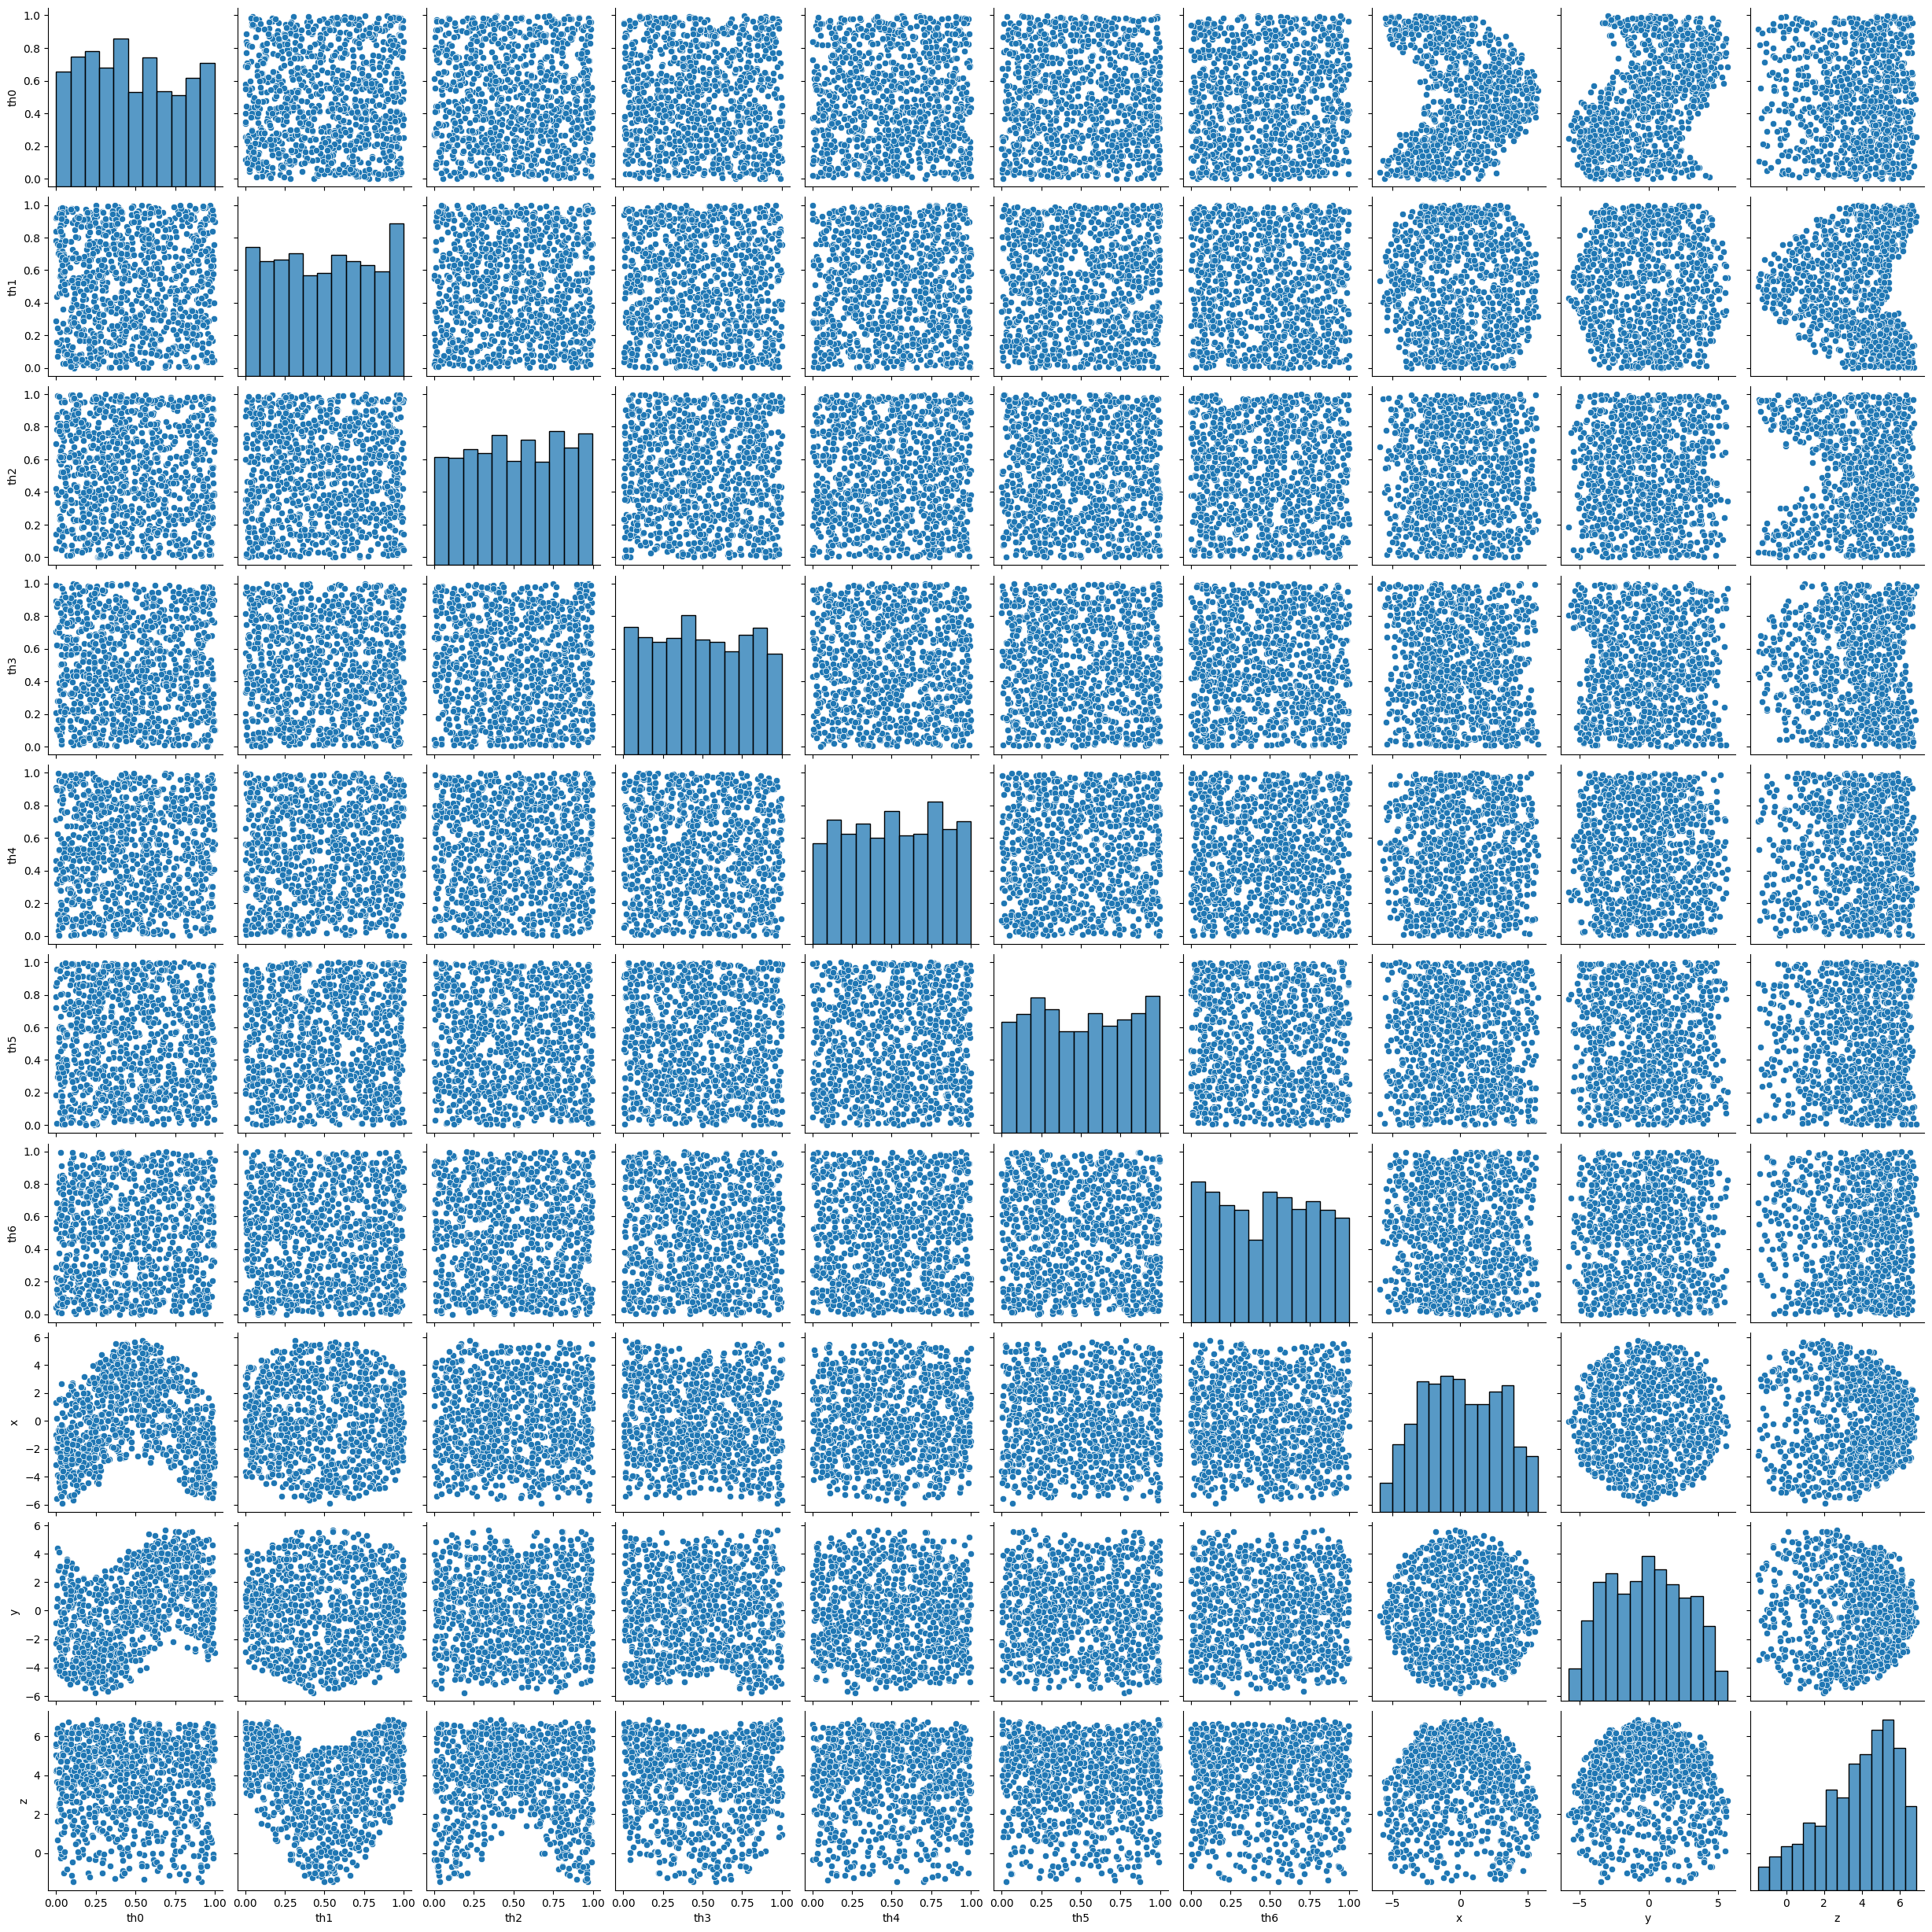

In [66]:
# Convert inputs to DataFrame
df = pd.DataFrame(labels, columns=['th0', 'th1', 'th2', 'th3', 'th4', 'th5', 'th6'])

# Add a class label column (assuming the first column of 'outputs' indicates class 0)
#df['Class'] = labels[:, 0]  # This sets 1 for class 0 and 0 for class 1

df[['x', 'y', 'z']] = pd.DataFrame(features, index=df.index)

# Use seaborn's pairplot
#sns.pairplot(df, hue='Class', palette='bright')
# Show the plot
#plt.show()

#for i in range(1, 4):
#sns.pairplot(df, x_vars=['th0', 'th0', 'th0', 'th0', 'th0', 'th0', 'th0'], y_vars=['x', 'y', 'z'])
sns.pairplot(df)
plt.savefig("plotDaneV6_171223_1k.pdf", format='pdf')
plt.show()

In [47]:
features = data[:, :3]  # XYZ positions
labels = data[:, 3:]   # Angles
labels_image = []
for i in range(0, len(labels)):
    n = len(labels[i])
    matrix = np.empty((n, n))
    for j in range(n):
        matrix[j] = np.roll(labels[i], j)
    labels_image.append(matrix)

np.save('Danef.npy', features)
np.save('Danel.npy', labels_image)

In [46]:
print(labels_image[0])

[[0.33477373 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.33477373 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.33477373 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.33477373 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.33477373 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.33477373
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.33477373]]


In [31]:
plot_3d_points(robot_conf, [3,3,7])

In [35]:
plot_3d_arm_simple(robot_conf, [2,2,7])

In [229]:
plot_3d_arm10([simple_conf], [2,2,1], 3)

In [227]:
plot_3d_arm10([robot_conf], [2,2,7], 3)

In [104]:
# Create a SOM network
net = sps.SOMNet(5, 5, data, PBC=True)

Periodic Boundary Conditions active.
The weights will be initialized with PCA.


In [105]:
# Train the network
net.train()

The map will be trained with the batch algorithm.
Training SOM... done!


<Figure size 3000x1000 with 0 Axes>

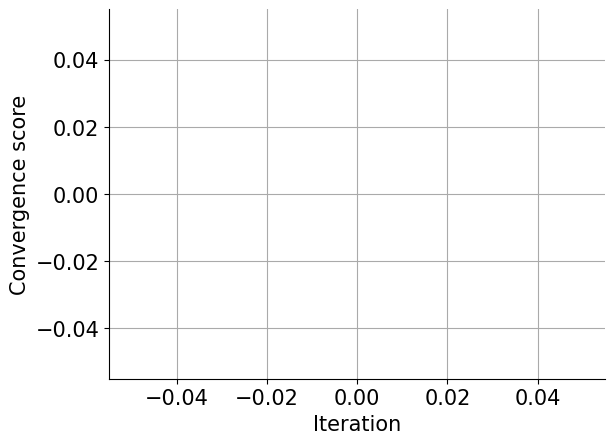

In [106]:
net.plot_convergence()

In [107]:
net.save('SOMv1', out_path='models/')

In [108]:
net.cluster(data, clus_type='qthresh')

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

<Figure size 640x480 with 0 Axes>

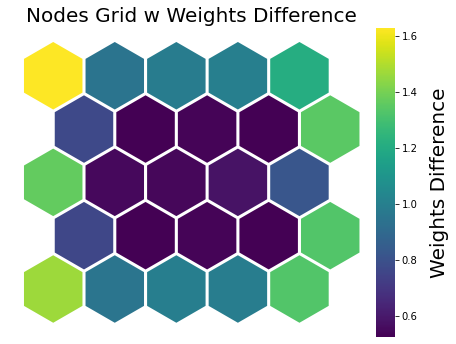

In [109]:
net.diff_graph()

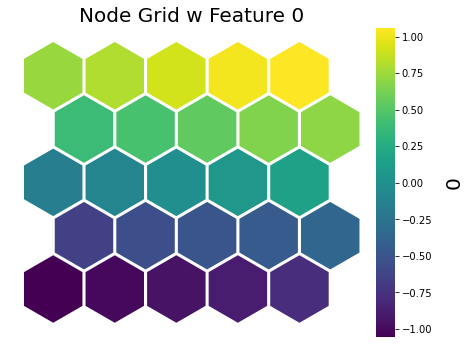

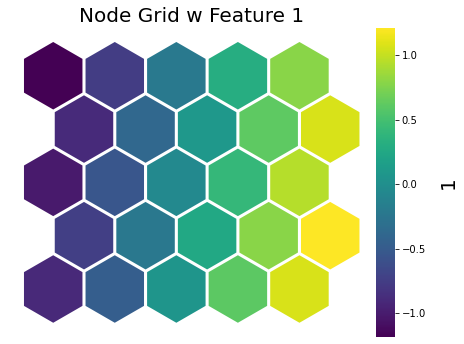

In [112]:
net.nodes_graph(colnum=0)
net.nodes_graph(colnum=1)